In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import Ofpp
import os
import subprocess

def load_material_properties(case_path, config_file_name):
    command = f'source {os.path.join(case_path, config_file_name)} && env'
    #print(command)
    var_names = ['RHO', 'FluidCP', 'RHO_s', 'SolidCP', 'porosity', 'wallTemp', 'R', 'FluidPr', 'SolidK', 'MU', 'inletTemp', 'Rchannels']
    result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, executable='/bin/bash', text=True)

    # Parse the output to find only the desired variables
    env_vars = {}
    for line in result.stdout.splitlines():
        key, _, value = line.partition('=')
        if key in var_names:
            env_vars[key] = value
    #print(env_vars.get('RHO', None), env_vars.get('FluidCP', None), env_vars.get('RHO_s', None), env_vars.get('SolidCP', None), env_vars.get('porosity', None), env_vars.get('wallTemp', None), env_vars.get('R', None), env_vars.get('FluidPr', None), env_vars.get('SolidK', None), env_vars.get('MU', None))

    return float(env_vars.get('RHO', None)), float(env_vars.get('FluidCP', None)), float(env_vars.get('RHO_s', None)), float(env_vars.get('SolidCP', None)), float(env_vars.get('porosity', None)), float(env_vars.get('wallTemp', None)), float(env_vars.get('R', None))*0.001, float(env_vars.get('FluidPr', None)), float(env_vars.get('SolidK', None)), float(env_vars.get('MU', None)), float(env_vars.get('inletTemp', None)), float(env_vars.get('Rchannels', None))*0.001

def getAvg_p_rgh(case_path, timeSteps, field, num_zdots, region='FluidRegion/'):

    mesh = Ofpp.FoamMesh(case_path,region)
    mesh.read_cell_centres(case_path+'0/'+region+'C')
    mesh.read_cell_volumes(case_path+'0/'+region+'V')
    mesh.read_face_areas(case_path+'0/'+region+'C')

    field_parses = []
    for time in timeSteps:
        field_parses.append(Ofpp.parse_internal_field(case_path+time+'/'+region+field))

    min_z = min([centre[2] for centre in mesh.cell_centres])
    print("Minimum Z coordinate: ", min_z)

    max_z = max([centre[2] for centre in mesh.cell_centres])
    print("Maximum Z coordinate: ", max_z)

    # Get linspaced points in between:
    zdots = np.linspace(min_z, max_z, num_zdots)

    # Save index of cells in each of the samnple sections:
    indexes=[[] for _ in range(num_zdots-1)]

    for i in range(0,mesh.num_cell):
        z = mesh.cell_centres[i][2]
        for j in range(1,num_zdots):
            if (z >= zdots[j-1]) and (z<=zdots[j]):
                indexes[j-1].append(i)

    # For each timestep
    p_rgh_sectionAvg=[[0.0]*(num_zdots-1) for _ in range(len(timeSteps))]
    for k in range(len(timeSteps)):
        for j in range(0,num_zdots-1):
            total_cell_vol = np.sum([mesh.cell_volumes[i] for i in indexes[j]])
            p_rgh_sectionAvg[k][j]=np.sum([field_parses[k][i]*mesh.cell_volumes[i]/total_cell_vol for i in indexes[j]])

    z_mean_dots=[(zdots[i-1]+zdots[i])/2.0 for i in range(1,num_zdots)]

    return z_mean_dots, p_rgh_sectionAvg, zdots

def get_pressureZgrad(linear_zone_start, linear_zone_end, p_rgh, zdots):
    grad = [(p_rgh[i+1]-p_rgh[i])/(zdots[i]-zdots[i-1]) for i in range(1, len(zdots)) if (zdots[i]>linear_zone_start) and (zdots[i]<linear_zone_end)]
    #p_rgh_case1[time]
    p_gradient=np.mean(grad)

    return p_gradient

"""
def get_Tprofile(case_path, timeSteps, num_zdots, field='T'):

    # Get the material properties of solid and fluid:
    config_file_name='caseConfig.sh'
    fluidRho, fluidCp, solidRho, solidCp, porosity, wallTemp, R, FluidPr, SolidK, fluidMU = load_material_properties(case_path, config_file_name)
    FluidK = fluidCp*fluidMU/FluidPr
    
    print(fluidRho, fluidCp, solidRho, solidCp, porosity)


    # Read the meshes for both regions
    fluidRegion='FluidRegion/'
    solidRegion='CatalystRegion/'

    fluidMesh = Ofpp.FoamMesh(case_path, fluidRegion)
    fluidMesh.read_cell_centres(case_path + '0/' + fluidRegion + 'C')
    fluidMesh.read_cell_volumes(case_path + '0/' + fluidRegion + 'V')
    fluidMesh.read_face_areas(case_path + '0/' + fluidRegion + 'C')

    solidMesh = Ofpp.FoamMesh(case_path, solidRegion)
    solidMesh.read_cell_centres(case_path+'0/'+ solidRegion + 'C')
    solidMesh.read_cell_volumes(case_path+'0/'+ solidRegion + 'V')
    solidMesh.read_face_areas(case_path+'0/'+ solidRegion + 'C')

    # Read the desired fields (T) for both regions
    fluid_field_parses = []
    for time in timeSteps:
        fluid_field_parses.append(Ofpp.parse_internal_field(case_path + time + '/' + fluidRegion + field))

    solid_field_parses = []
    for time in timeSteps:
        solid_field_parses.append(Ofpp.parse_internal_field(case_path + time + '/' + solidRegion + field))

    # Get the minimum and maximum z values in the solid mesh (since 
    # it is where the porous media starts, i am not interested in 
    # what happens before or after):
    min_z = min([centre[2] for centre in solidMesh.cell_centres])
    print("Minimum Z coordinate of the porous media: ", min_z)

    max_z = max([centre[2] for centre in solidMesh.cell_centres])
    print("Maximum Z coordinate of the porous media: ", max_z)

    # Get linspaced points in between:
    zdots = np.linspace(min_z, max_z, num_zdots)

    # Save index of cells in each of the sample sections, for each region:
    indexesFluid=[[] for _ in range(num_zdots-1)]
    indexesSolid=[[] for _ in range(num_zdots-1)]


    for i in range(0,fluidMesh.num_cell):
        z = fluidMesh.cell_centres[i][2]
        for j in range(1,num_zdots):
            if (z >= zdots[j-1]) and (z<=zdots[j]):
                indexesFluid[j-1].append(i)

    for i in range(0,solidMesh.num_cell):
        z = solidMesh.cell_centres[i][2]
        for j in range(1,num_zdots):
            if (z >= zdots[j-1]) and (z<=zdots[j]):
                indexesSolid[j-1].append(i)

    # Get the temperatures in solid and fluid as sets of points
    # For each timestep
    TprofileFluid=[]
    TprofileSolid=[]
    # Values for the radius are the same for all timesteps:
    rvalsFluid = []
    rvalsSolid = []
    for j in range(0,num_zdots-1):
        rvalsFluid.append([np.linalg.norm([fluidMesh.cell_centres[i][0],fluidMesh.cell_centres[i][1]]) for i in indexesFluid[j]])
        rvalsSolid.append([np.linalg.norm([solidMesh.cell_centres[i][0],solidMesh.cell_centres[i][1]]) for i in indexesSolid[j]])

    for k in range(len(timeSteps)):
        # Temperature profile for this timestep:
        timeStepTprofileFluid = []
        timeStepTprofileSolid = []

        for j in range(0,num_zdots-1):
            # For all the cell centers in this section, I will save the value of temperature 
            # and the radial position of the center of the cell
            TvalsFluid = [fluid_field_parses[k][i] for i in indexesFluid[j]]
            TvalsSolid = [solid_field_parses[k][i] for i in indexesSolid[j]]

            timeStepTprofileFluid.append(TvalsFluid)
            timeStepTprofileSolid.append(TvalsSolid)

        # Save the current timestep velues in the return vector:
        TprofileFluid.append(timeStepTprofileFluid)
        TprofileSolid.append(timeStepTprofileSolid)

    # Average temperature in each region:
    Tavg_fluid = []
    Tavg_solid = []
    Tavg = []
    for k in range(len(timeSteps)):
        Tavg_fluid_currentTimestep = []
        Tavg_solid_currentTimestep = []
        Tavg_currentTimestep = []
        for j in range(0,num_zdots-1):
            totalVolFluidCells = np.sum([fluidMesh.cell_volumes[i] for i in indexesFluid[j]])
            totalVolSolidCells = np.sum([solidMesh.cell_volumes[i] for i in indexesSolid[j]])

            TavFluid = np.sum([fluid_field_parses[k][i]*fluidMesh.cell_volumes[i]/totalVolFluidCells for i in indexesFluid[j]])
            TavSolid = np.sum([solid_field_parses[k][i]*solidMesh.cell_volumes[i]/totalVolSolidCells for i in indexesSolid[j]])

            TavSection = (fluidRho*fluidCp*porosity*TavFluid + solidRho*solidCp*(1-porosity)*TavSolid)/(fluidRho*fluidCp*porosity + solidRho*solidCp*(1-porosity))

            Tavg_fluid_currentTimestep.append(TavFluid)
            Tavg_solid_currentTimestep.append(TavSolid)
            Tavg_currentTimestep.append(TavSection)

        Tavg_fluid.append(Tavg_fluid_currentTimestep)
        Tavg_solid.append(Tavg_solid_currentTimestep)
        Tavg.append(Tavg_currentTimestep)

    z_mean_dots=[(zdots[i-1]+zdots[i])/2.0 for i in range(1,num_zdots)]
    # fz is the axial temperature profile for each timestep
    dTbdz = [np.gradient(fz,z_mean_dots) for fz in Tavg]

    # Equivalent k
    #keq=SolidK
    keq=SolidK*(1-porosity) + FluidK*porosity

    H_convCoeff = [np.array([2.0*np.pi*keq*dTbdz[i][j]*(wallTemp-Tavg[i][j])/R for j in range(0,len(dTbdz[i]))]) for i in range(0,len(Tavg))]
    Nu = [H_currTimeStep*(R/keq) for H_currTimeStep in H_convCoeff]


    return TprofileFluid, TprofileSolid, rvalsFluid, rvalsSolid, zdots, z_mean_dots, Tavg_fluid, Tavg_solid, Tavg, dTbdz, Nu
"""
"""
def get_radial_Tprofile(case_path, timeStep, num_zdots, num_rdots, sizeRfilter, field='T'):
    # Get the material properties of solid and fluid:
    config_file_name='caseConfig.sh'
    fluidRho, fluidCp, solidRho, solidCp, porosity, wallTemp, R, FluidPr, SolidK, fluidMU, inletTemp, Rchannels = load_material_properties(case_path, config_file_name)

    FluidK = fluidCp*fluidMU/FluidPr
    rhocp_avg_global = solidRho*solidCp*(1-porosity) + fluidRho*fluidCp*porosity
    
    print(fluidRho, fluidCp, solidRho, solidCp, porosity)


    # Read the meshes for both regions
    fluidRegion='FluidRegion/'
    solidRegion='CatalystRegion/'

    fluidMesh = Ofpp.FoamMesh(case_path, fluidRegion)
    fluidMesh.read_cell_centres(case_path + '0/' + fluidRegion + 'C')
    fluidMesh.read_cell_volumes(case_path + '0/' + fluidRegion + 'V')
    fluidMesh.read_face_areas(case_path + '0/' + fluidRegion + 'C')

    solidMesh = Ofpp.FoamMesh(case_path, solidRegion)
    solidMesh.read_cell_centres(case_path+'0/'+ solidRegion + 'C')
    solidMesh.read_cell_volumes(case_path+'0/'+ solidRegion + 'V')
    solidMesh.read_face_areas(case_path+'0/'+ solidRegion + 'C')

    # Read the desired fields (T) for both regions
    fluid_field_parses = Ofpp.parse_internal_field(case_path + timeStep + '/' + fluidRegion + field)
    solid_field_parses = Ofpp.parse_internal_field(case_path + timeStep + '/' + solidRegion + field)

    # Get the minimum and maximum z values in the solid mesh (since 
    # it is where the porous media starts, i am not interested in 
    # what happens before or after):
    min_z = min([centre[2] for centre in solidMesh.cell_centres])
    print("Minimum Z coordinate of the porous media: ", min_z)

    max_z = max([centre[2] for centre in solidMesh.cell_centres])
    print("Maximum Z coordinate of the porous media: ", max_z)

    # Get linspaced points in between:
    zdots = np.linspace(min_z, max_z, num_zdots) # - (max_z-min_z)*0.2
    rdots = np.linspace(0, R, num_rdots)

    # Save index of cells in each of the sample sections, for each region:
    indexesFluid=[[] for _ in range(num_zdots-1)]
    indexesSolid=[[] for _ in range(num_zdots-1)]


    for i in range(0,fluidMesh.num_cell):
        z = fluidMesh.cell_centres[i][2]
        for j in range(1,num_zdots):
            if (z >= zdots[j-1]) and (z<=zdots[j]):
                indexesFluid[j-1].append(i)

    for i in range(0,solidMesh.num_cell):
        z = solidMesh.cell_centres[i][2]
        for j in range(1,num_zdots):
            if (z >= zdots[j-1]) and (z<=zdots[j]):
                indexesSolid[j-1].append(i)

    # In each of the z sections, get the values of interest
    Tref=0
    Tprof = []
    TavgSec = []
    TavgSecSolid = []
    TavgSecFluid = []
    KavSec = []
    rdots_cells = []
    Tvals_cells = []
    for zi in range(0,num_zdots-1):
        # Save the radius, volume and thermal inertia of each cell in each of the regions.
        Tdata = []
        TsolidData = []
        TfluidData = []
        rdotsloc = []
        Tdotsloc = []
        for i in indexesFluid[zi]:
            r = np.sqrt((fluidMesh.cell_centres[i][0]**2) + (fluidMesh.cell_centres[i][1]**2))
            V = fluidMesh.cell_volumes[i]
            rhocp = fluidRho*fluidCp
            T = fluid_field_parses[i]

            rdotsloc.append(r)
            Tdotsloc.append(T)

            TM = rhocp*V*(T-Tref)
            cellData = [r,TM,V,rhocp, FluidK]
            Tdata.append(cellData)
            TfluidData.append(cellData)

        for i in indexesSolid[zi]:
            r = np.sqrt((solidMesh.cell_centres[i][0]**2) + (solidMesh.cell_centres[i][1]**2))
            V = solidMesh.cell_volumes[i]
            rhocp = solidRho*solidCp
            T = solid_field_parses[i]

            rdotsloc.append(r)
            Tdotsloc.append(T)

            TM = rhocp*V*(T-Tref)
            cellData = [r,TM,V,rhocp, SolidK]
            Tdata.append(cellData)
            TsolidData.append(cellData)

        # Average temperature in the section
        Ta = sum([TM[1] for TM in Tdata]) / sum([TM[3]*TM[2] for TM in Tdata]) + Tref
        TavgSec.append(Ta)

        # Average temperature in the fluid
        Tf = sum([TM[1] for TM in TfluidData]) / sum([TM[3]*TM[2] for TM in TfluidData]) + Tref
        TavgSecFluid.append(Tf)
        
        # Average temperature in the solid
        Ts = sum([TM[1] for TM in TsolidData]) / sum([TM[3]*TM[2] for TM in TsolidData]) + Tref
        TavgSecSolid.append(Ts)

        # Calculate the average temperature in each ring
        locProf = []
        # Average heat conduction coefficient in each ring:
        KavProf = []
        #print(rdots)
        for rval in rdots:
            totTM = np.sum([Tdata[i][1] for i in range(0,len(Tdata)) if ((Tdata[i][0]>(rval-sizeRfilter/2)) and (Tdata[i][0]<(rval+sizeRfilter/2)))])
            totV = np.sum([Tdata[i][2] for i in range(0,len(Tdata)) if ((Tdata[i][0]>(rval-sizeRfilter/2)) and (Tdata[i][0]<(rval+sizeRfilter/2)))])
            totrhocpV = np.sum([Tdata[i][2]*Tdata[i][3] for i in range(0,len(Tdata)) if ((Tdata[i][0]>(rval-sizeRfilter/2)) and (Tdata[i][0]<(rval+sizeRfilter/2)))])
            # Average rhocp in the current ring:
            if (totV==0) or (totV == float('nan') ):
                print('Problema con la seccion ', zi)
            avgrhocp = totrhocpV/totV
            avgT = Tref + totTM/(avgrhocp*totV)
            Kav = sum([Tdata[i][4]*Tdata[i][2] for i in range(0,len(Tdata)) if ((Tdata[i][0]>(rval-sizeRfilter/2)) and (Tdata[i][0]<(rval+sizeRfilter/2)))])/totV

            locProf.append(avgT)
            KavProf.append(Kav)

        Tprof.append(locProf)
        rdots_cells.append(rdotsloc)
        Tvals_cells.append(Tdotsloc)
        KavSec.append(KavProf)

        parameters = (fluidRho, fluidCp, solidRho, solidCp, porosity, wallTemp, R, FluidPr, SolidK, fluidMU, inletTemp, Rchannels)
        res = (Tprof, rdots, rdots_cells, Tvals_cells, TavgSec, TavgSecFluid, TavgSecSolid, zdots, KavSec, parameters)

    return res
"""

def get_radial_Tprofile(case_path, timeStep, num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T'):
    # Get the material properties of solid and fluid:
    config_file_name='caseConfig.sh'
    fluidRho, fluidCp, solidRho, solidCp, porosity, wallTemp, R, FluidPr, SolidK, fluidMU, inletTemp, Rchannels = load_material_properties(case_path, config_file_name)

    FluidK = fluidCp*fluidMU/FluidPr
    rhocp_avg_global = solidRho*solidCp*(1-porosity) + fluidRho*fluidCp*porosity
    
    print(fluidRho, fluidCp, solidRho, solidCp, porosity)


    # Read the meshes for both regions
    fluidRegion='FluidRegion/'
    solidRegion='CatalystRegion/'

    fluidMesh = Ofpp.FoamMesh(case_path, fluidRegion)
    fluidMesh.read_cell_centres(case_path + '0/' + fluidRegion + 'C')
    fluidMesh.read_cell_volumes(case_path + '0/' + fluidRegion + 'V')
    fluidMesh.read_face_areas(case_path + '0/' + fluidRegion + 'C')

    solidMesh = Ofpp.FoamMesh(case_path, solidRegion)
    solidMesh.read_cell_centres(case_path+'0/'+ solidRegion + 'C')
    solidMesh.read_cell_volumes(case_path+'0/'+ solidRegion + 'V')
    solidMesh.read_face_areas(case_path+'0/'+ solidRegion + 'C')

    # Read the desired fields (T) for both regions
    fluid_field_parses = Ofpp.parse_internal_field(case_path + timeStep + '/' + fluidRegion + field)
    solid_field_parses = Ofpp.parse_internal_field(case_path + timeStep + '/' + solidRegion + field)

    # Get the minimum and maximum z values in the solid mesh (since 
    # it is where the porous media starts, i am not interested in 
    # what happens before or after):
    min_z = min([centre[2] for centre in solidMesh.cell_centres])
    print("Minimum Z coordinate of the porous media: ", min_z)

    max_z = max([centre[2] for centre in solidMesh.cell_centres])
    print("Maximum Z coordinate of the porous media: ", max_z)

    # Get linspaced points in between:
    zdots = np.linspace(min_z, max_z, num_zdots) # - (max_z-min_z)*0.2
    rdots = np.linspace(0, R, num_rdots)

    # Save index of cells in each of the sample sections, for each region:
    indexesFluid=[[] for _ in range(num_zdots)]
    indexesSolid=[[] for _ in range(num_zdots)]


    for i in range(0,fluidMesh.num_cell):
        z = fluidMesh.cell_centres[i][2]

        for j in range(0,num_zdots):
            if (z >= (zdots[j]-sizeZfilter/2.0)) and (z<=(zdots[j]+sizeZfilter/2.0)):
                indexesFluid[j].append(i)

    #for i in range(0,solidMesh.num_cell):
    for i in range(0,len(solidMesh.cell_centres)):
        z = solidMesh.cell_centres[i][2]
        for j in range(0,num_zdots):
            if (z >= (zdots[j]-sizeZfilter/2.0)) and (z<=(zdots[j]+sizeZfilter/2.0)):
                indexesSolid[j].append(i)

    # In each of the z sections, get the values of interest
    Tref=0
    TavgSec = []
    TavgSecSolid = []
    TavgSecFluid = []
    KavSec = []
    for zi in range(0,num_zdots):
        # Save the radius, volume and thermal inertia of each cell in each of the regions.
        Tdata = []
        TsolidData = []
        TfluidData = []
        for i in indexesFluid[zi]:

            r = np.sqrt((fluidMesh.cell_centres[i][0]**2) + (fluidMesh.cell_centres[i][1]**2))
            V = fluidMesh.cell_volumes[i]
            rhocp = fluidRho*fluidCp
            T = fluid_field_parses[i]


            TM = rhocp*V*(T-Tref)
            cellData = [r,TM,V,rhocp, FluidK]
            Tdata.append(cellData)
            TfluidData.append(cellData)

        for i in indexesSolid[zi]:
            r = np.sqrt((solidMesh.cell_centres[i][0]**2) + (solidMesh.cell_centres[i][1]**2))
            V = solidMesh.cell_volumes[i]
            rhocp = solidRho*solidCp
            T = solid_field_parses[i]
            

            TM = rhocp*V*(T-Tref)
            cellData = [r,TM,V,rhocp, SolidK]
            Tdata.append(cellData)
            TsolidData.append(cellData)

        # Average temperature in the section
        Ta = sum([TM[1] for TM in Tdata]) / sum([TM[3]*TM[2] for TM in Tdata]) + Tref
        TavgSec.append(Ta)

        # Average temperature in the fluid
        Tf = sum([TM[1] for TM in TfluidData]) / sum([TM[3]*TM[2] for TM in TfluidData]) + Tref
        TavgSecFluid.append(Tf)
        
        # Average temperature in the solid
        Ts = sum([TM[1] for TM in TsolidData]) / sum([TM[3]*TM[2] for TM in TsolidData]) + Tref
        TavgSecSolid.append(Ts)

        parameters = (fluidRho, fluidCp, solidRho, solidCp, porosity, wallTemp, R, FluidPr, SolidK, fluidMU, inletTemp, Rchannels)
        res = (TavgSec, TavgSecFluid, TavgSecSolid, zdots, KavSec, parameters)

    return res




## Problemas con las curvas
Las variables medias calculadas a partir de las simulaciones, por un motivo que no llego a comprender del todo, presentan oscilaciones, y al derivar esas osculaciones me quedan cosas que oscilan más todavía y me impoden sacar ningçun resultado. Un acercamiento para solucionar eso puede ser, en vez de derivar esos resultados directamente, ajustar alguna curva suave adecuada y derivar esa curva, que es lo que hago justo a continuación.

Propongo que la curva de $\langle v_z T\rangle$ pueda ajustarse adecuadamente como una exponencial de la forma:

$\langle v_z T\rangle(z) \approx a + b e^{-cz}$

Donde tengo que ajustar los parámetros $a$, $b$ y $c$ por mínimos cuadrados:

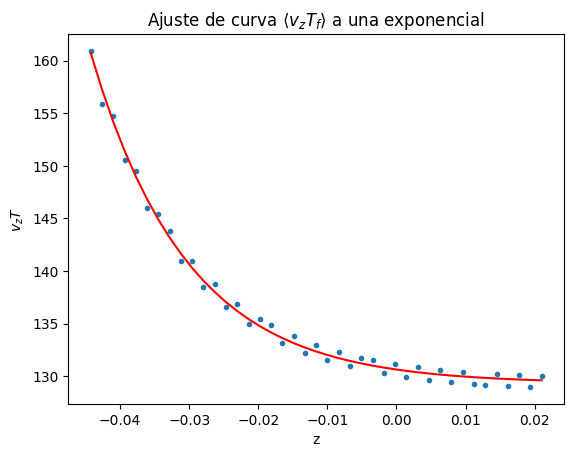

Curve adjusted to: a =  129.30214187861372  b =  1.3215234065605888  and c =  71.61808167452669


In [ ]:
# Adjustment of curve <vT> to an exponential by minimum squares

from scipy.optimize import fsolve
# Points to fit to:


def grad_funExp(p,*data):
    a = p[0]
    b = p[1]
    c = p[2]
    z, y = data
    dEda = sum([-2*(y[i] - a - b*np.exp(-c*z[i])) for i in range(0,len(z))])
    dEdb = sum([-2*(y[i] - a - b*np.exp(-c*z[i]))*np.exp(-c*z[i]) for i in range(0,len(z))])
    dEdc = sum([2*(y[i] - a - b*np.exp(-c*z[i]))*b*np.exp(-c*z[i])*z[i] for i in range(0,len(z))])

    return [dEda, dEdb, dEdc]

p0 = [130, 3, 50]
#p0 = [40, 0.0015, 70]
data = (zmiddles[-80:-5], vTf_Avg[-80:-5])
adjust_paramsvTf = fsolve(grad_funExp, p0, args=data)

plt.scatter(zmiddles[3:-5], vTf_Avg[3:-5], marker='.', label="Data from simulation")
a=adjust_paramsvTf[0]
b=adjust_paramsvTf[1]
c=adjust_paramsvTf[2]
plt.plot(zmiddles[3:-5], [a+b*np.exp(-c*z) for z in zmiddles[3:-5]], color='red', label="Adjusted exponential curve")
plt.title(r"Ajuste de curva $\langle v_z T_f\rangle$ a una exponencial")
plt.xlabel(r"z")
plt.ylabel(r"$v_z T$")
plt.show()

print("Curve adjusted to: a = ", a, " b = ", b, " and c = ", c)

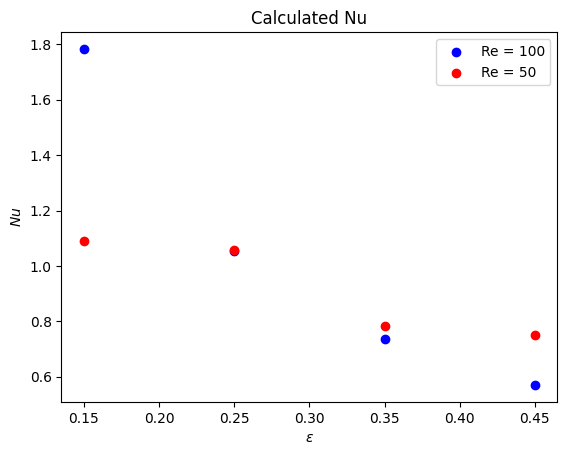

In [ ]:
# Caso con 
# [Porosity, Re, channelR, lambda1, a1, b1, c1, d1, Nu]
caso1 = [0.35, 100, 1.479019945774904, 62.512480791233315, 1.957061776875017, 3.1907699758996104, 0.06952397374272333, 1.1398967391265236, 0.7381651218225298]
caso2 = [0.25, 100, 1.5075567228888183, 67.88828969891489, 1.495386289865671, 2.58280625200488, 0.038801898121125625, 0.6590889081897741, 1.0525903614099081]
caso3 = [0.55, 50, 1.2030662579644695]
caso4 = [0.15, 100, 1.4638501094227998, 66.69008493183824, 1.5181695856012596, 2.510683573227972, 0.017672267994046843, 0.38234036975209756, 1.783305748247356]
caso5 = [0.45, 100, 1.5, 64.63984682519514, 1.885607491960383, 3.2595783809388204, 0.14883466084140706, 1.5308487307218615, 0.5706398204508351]

caso6_noTrust = [0.15, 50, 1.4638501094227998, 165.82774563368005, 0.004071395528556534, 0.03356084722384051, 0.0003728697183699531, 0.005153205520415793, 1.0908004901389583]
caso7 = [0.25, 50, 1.5075567228888183, 68.13975193506758, 0.7927314565715123, 1.3693015252049825, 0.020444786807826586, 0.3494658696138439, 1.0562182460108496]
caso8 = [0.35, 50, 1.479019945774904, 116.23380964777213, 0.04855447859154472, 0.15273586565273498, 0.003970974745163431, 0.054999586250290174, 0.7837428263051303]
caso9 = [0.45, 50, 1.5, 126.81997785205029, 0.03970569670012027, 0.13524102495631135, 0.009735543921962325, 0.06564397556525955, 0.752108560183903]


plt.scatter([caso1[0], caso2[0], caso4[0], caso5[0]], [caso1[8], caso2[8], caso4[8], caso5[8]], color='blue', label='Re = 100')
plt.scatter([caso6_noTrust[0], caso7[0], caso8[0], caso9[0]], [caso6_noTrust[8], caso7[8], caso8[8], caso9[8]], color='red', label='Re = 50')
plt.title("Calculated Nu")
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$Nu$")
plt.legend()
plt.show()


El ajuste de la temperatura en el sólido a una exponencial no es demasiado bueno. Puedo intentar probar otra curva como una función racional:

$\langle T_s \rangle \approx a + \frac{b}{{(z + c)^d}}$

Bueno, como no consigo ajustar la funcion racional voy a limitarme a ajustar la exponencial a los últimos puntos y call it a day. Now I am going to calculate the derivatives for the Nusselt Number:

## Compare prediction with simulations
Here I will get the results from the simulations, nondimensionalize them and then compare with the predictions from my model:

In [ ]:
num_zdots=60
num_rdots=10
sizeRfilter=0.001

import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def nondimensionalize(res):
    """
    This function gets the results from the simulation and returns some of the variables nondimensionalized
    """
    TavgSec, TavgSecFluid, TavgSecSolid, zdots, KavSec, parameters = res
    fluidRho, fluidCp, solidRho, solidCp, porosity, wallTemp, R, FluidPr, SolidK, fluidMU, inletTemp,  Rchannels = parameters
    
    # In principle I am only interested in the nondimensionalized version of average 
    # temperature in the solid, in the fluid, and distances (z)
    zmin = min(zdots)
    zmax = max(zdots)

    z_nondim = [(z-zmin)/R for z in zdots]
    Tdif = inletTemp - wallTemp
    TsolidNondim = [(T - wallTemp)/Tdif for T in TavgSecSolid]
    TfluidNondim = [(T - wallTemp)/Tdif for T in TavgSecFluid]

    return z_nondim, TsolidNondim, TfluidNondim

def adjust_to_exponential_coupled(z_nondim, TsolidNondim, TfluidNondim, zcutoff0):
    """
    This function receives two nondimensional temperature profiles 
    and fits an exponential curve to each of them, so that the exponent 
    of the exponential function is the best fit for both:
    """
    z_centers = [(z_nondim[i] + z_nondim[i+1])/2.0 for i in range(0,len(z_nondim)-1)]
    # Chose a value for the reference z
    # (Since temperature in the fluid is way larger than in the solid, 
    # if I try to best fit the same decay rate to both, the least squares 
    # will give a grater importance to the fluid. To avoid that, I will 
    # divide both of the sets of points by an interpolation of the value 
    # of the series in a reference section, so that both of the sets of 
    # curves are of the same magnitude)
    zref = 1 # Remember this is already nondimensional, z=1 is a distance R away from the inlet
    refTsol = np.interp(zref, z_centers, TsolidNondim)
    refTflu = np.interp(zref, z_centers, TfluidNondim)

    # Divide the temperatures by the reference:
    Tsol_ref = np.array(TsolidNondim)*(1/refTsol)
    Tflu_ref = np.array(TfluidNondim)*(1/refTflu)

    data = (z_centers, Tsol_ref, Tflu_ref)

    def errCuad(zcutoff, pr, data):
        z_centers, Tsol_ref, Tflu_ref = data
        # Points we are taking into account: those whose z is larger than cutoff
        indexes = [i for i in range(0,len(z_centers)) if z_centers[i]>=zcutoff]
        n = 2*len(indexes)
        lan = pr[0]
        gamS = pr[1]
        gamF = pr[2]
        Ec = (1/n)*(sum([(gamS*np.exp(-lan*z_centers[i]) - Tsol_ref[i])**2 for i in indexes])+sum([(gamF*np.exp(-lan*z_centers[i]) - Tflu_ref[i])**2 for i in indexes]))

        return Ec

    def grad_funExp(p,*data):
        z_centers, Tsol_ref, Tflu_ref = data

        zcutoff = p[0]
        lan = p[1]
        gamS = p[2]
        gamF = p[3]
        pr = [lan, gamS, gamF]

        indexes = [i for i in range(0,len(z_centers)) if z_centers[i]>=zcutoff]

        dEdzcutoff = 0.0
        """
        if (zcutoff < z_centers[0]):
            dEdzcutoff = 0.0

        elif (zcutoff >= z_centers[0]) and (zcutoff<z_centers[1]):
            E0 = errCuad(zcutoff, pr, data)
            E1 = errCuad((z_centers[2]+z_centers[1])/2.0, pr, data)
            dEdzcutoff = (E1-E0)/(z_centers[1]-z_centers[0])

        elif (zcutoff<z_centers[-2]):
            # First index of z_centers smaller than zcutoff
            fis = indexes[0]-1
            E_1 = errCuad((z_centers[fis]+z_centers[fis-1])/2.0, pr, data)
            E0 = errCuad(zcutoff, pr, data)
            E1 = errCuad((z_centers[fis+2]+z_centers[fis+1])/2.0, pr, data)

            z0 = z_centers[fis] + (1/4)*(z_centers[fis+1]-z_centers[fis])
            z1 = z_centers[fis] + (2/4)*(z_centers[fis+1]-z_centers[fis])
            z2 = z_centers[fis] + (3/4)*(z_centers[fis+1]-z_centers[fis])
            d1 = (E0-E_1)/(z1-z0)
            d2 = (E1-E0)/(z2-z1)
            dEdzcutoff = d1 + (d2-d1)*(zcutoff-z0)/(z2-z0)

        else:
            print("zcutoff = ",zcutoff, " Length of pipe = ", max(z_centers))
            raise ValueError("zcutoff reaching end of the pipe")
        """

        n = 2*len(indexes)
        dEdgamS = (1/n)*(sum([2*(gamS*np.exp(-lan*z_centers[i]) - Tsol_ref[i])*np.exp(-lan*z_centers[i]) for i in indexes]))
        dEdgamF = (1/n)*(sum([2*(gamF*np.exp(-lan*z_centers[i]) - Tflu_ref[i])*np.exp(-lan*z_centers[i]) for i in indexes]))
        dEdlan =  (1/n)*(sum([2*(gamS*np.exp(-lan*z_centers[i]) - Tsol_ref[i])*(gamS*(-z_centers[i])*np.exp(-lan*z_centers[i])) for i in indexes])+
                         sum([2*(gamF*np.exp(-lan*z_centers[i]) - Tsol_ref[i])*(gamF*(-z_centers[i])*np.exp(-lan*z_centers[i])) for i in indexes]))

    
        return [dEdzcutoff, dEdlan, dEdgamS, dEdgamF]

    # Initial gesses:
    v2 = np.interp(zref+1, z_centers, Tsol_ref)
    lam0 = -np.log(v2)
    gamS0 = 1/np.exp(-lam0*zref)
    gamF0 = 1/np.exp(-lam0*zref)
    #zcutoff0 = 1.0
    p0 = [zcutoff0, lam0, gamS0, gamF0]
    adjust_paramsvTf = fsolve(grad_funExp, p0, args=data)

    #print("adjust_paramsvTf = ", adjust_paramsvTf)
    lamadj = adjust_paramsvTf[1]
    gamSadj = adjust_paramsvTf[2]
    gamFadj = adjust_paramsvTf[3]

    zdotsplot = np.linspace(0,max(z_centers),100)
    plt.plot(z_centers,Tsol_ref)
    plt.plot(zdotsplot,[gamSadj*np.exp(-lamadj*z) for z in zdotsplot])
    plt.show()
    zdotsplot = np.linspace(0,max(z_centers),100)
    plt.plot(z_centers,Tflu_ref)
    plt.plot(zdotsplot,[gamFadj*np.exp(-lamadj*z) for z in zdotsplot])
    plt.show()

    # Return the values to their magnitude:
    gamS = gamSadj*refTsol
    gamF = gamFadj*refTflu
    print(lamadj, gamS, gamF)

    return lamadj, gamS, gamF


    
def adjust_to_exponential_coupled_v2(z_nondim, TsolidNondim, TfluidNondim, z_rc_cutoff_fluid, z_R_cutoff_solid, rc_R):
    """
    This function receives two nondimensional temperature profiles 
    and fits an exponential curve to each of them, so that the exponent 
    of the exponential function is the best fit for both:

    The v2 version allows for different z cutoffs for the solid and the fluid
    """
    z_centers = [(z_nondim[i] + z_nondim[i+1])/2.0 for i in range(0,len(z_nondim)-1)]
    # Chose a value for the reference z
    # (Since temperature in the fluid is way larger than in the solid, 
    # if I try to best fit the same decay rate to both, the least squares 
    # will give a grater importance to the fluid. To avoid that, I will 
    # divide both of the sets of points by an interpolation of the value 
    # of the series in a reference section, so that both of the sets of 
    # curves are of the same magnitude)
    zref = 1 # Remember this is already nondimensional, z=1 is a distance R away from the inlet
    refTsol = np.interp(zref, z_centers, TsolidNondim)
    refTflu = np.interp(zref, z_centers, TfluidNondim)

    # Cutoff lengths (nondimensionalized with R):
    z_cutoff_fluid = z_rc_cutoff_fluid*rc_R
    z_cutoff_solid = z_R_cutoff_solid

    # Divide the temperatures by the reference:
    Tsol_ref = np.array(TsolidNondim)*(1/refTsol)
    Tflu_ref = np.array(TfluidNondim)*(1/refTflu)

    data = (z_centers, Tsol_ref, Tflu_ref, z_cutoff_fluid, z_cutoff_solid)

    def errCuad(z_cutoff_fluid, z_cutoff_solid, pr, data):
        z_centers, Tsol_ref, Tflu_ref = data
        # Points we are taking into account: those whose z is larger than cutoff
        indexes_f = [i for i in range(0,len(z_centers)) if z_centers[i]>=z_cutoff_fluid]
        indexes_s = [i for i in range(0,len(z_centers)) if z_centers[i]>=z_cutoff_solid]
        n = len(indexes_f) + len(indexes_s)
        lan = pr[0]
        gamS = pr[1]
        gamF = pr[2]
        Ec = (1/n)*(sum([(gamS*np.exp(-lan*z_centers[i]) - Tsol_ref[i])**2 for i in indexes_s])+sum([(gamF*np.exp(-lan*z_centers[i]) - Tflu_ref[i])**2 for i in indexes_s]))

        return Ec

    def grad_funExp(p,*data):
        z_centers, Tsol_ref, Tflu_ref, z_cutoff_fluid, z_cutoff_solid = data

        lan = p[0]
        gamS = p[1]
        gamF = p[2]
        pr = [lan, gamS, gamF]

        indexes_f = [i for i in range(0,len(z_centers)) if z_centers[i]>=z_cutoff_fluid]
        indexes_s = [i for i in range(0,len(z_centers)) if z_centers[i]>=z_cutoff_solid]

        n = len(indexes_f) + len(indexes_s)
        dEdgamS = (1/n)*(sum([2*(gamS*np.exp(-lan*z_centers[i]) - Tsol_ref[i])*np.exp(-lan*z_centers[i]) for i in indexes_s]))
        dEdgamF = (1/n)*(sum([2*(gamF*np.exp(-lan*z_centers[i]) - Tflu_ref[i])*np.exp(-lan*z_centers[i]) for i in indexes_f]))
        dEdlan =  (1/n)*(sum([2*(gamS*np.exp(-lan*z_centers[i]) - Tsol_ref[i])*(gamS*(-z_centers[i])*np.exp(-lan*z_centers[i])) for i in indexes_s])+
                         sum([2*(gamF*np.exp(-lan*z_centers[i]) - Tsol_ref[i])*(gamF*(-z_centers[i])*np.exp(-lan*z_centers[i])) for i in indexes_f]))

    
        return [dEdlan, dEdgamS, dEdgamF]

    # Initial gesses:
    v2 = np.interp(zref+1, z_centers, Tsol_ref)
    lam0 = -np.log(v2)
    gamS0 = 1/np.exp(-lam0*zref)
    gamF0 = 1/np.exp(-lam0*zref)
    #zcutoff0 = 1.0
    p0 = [lam0, gamS0, gamF0]
    adjust_paramsvTf = fsolve(grad_funExp, p0, args=data)

    #print("adjust_paramsvTf = ", adjust_paramsvTf)
    lamadj = adjust_paramsvTf[0]
    gamSadj = adjust_paramsvTf[1]
    gamFadj = adjust_paramsvTf[2]

    zdotsplot = np.linspace(0,max(z_centers),100)
    plt.plot(z_centers,Tsol_ref)
    plt.plot(zdotsplot,[gamSadj*np.exp(-lamadj*z) for z in zdotsplot])
    plt.show()
    zdotsplot = np.linspace(0,max(z_centers),100)
    plt.plot(z_centers,Tflu_ref)
    plt.plot(zdotsplot,[gamFadj*np.exp(-lamadj*z) for z in zdotsplot])
    plt.show()

    # Return the values to their magnitude:
    gamS = gamSadj*refTsol
    gamF = gamFadj*refTflu
    print(lamadj, gamS, gamF)

    return lamadj, gamS, gamF

"""
## FOR THE PREVIOUS DEFINITION OF ZCENTERS!!!
def adjust_to_exponential(z_nondim, TNondim, z_min, z_max):
    z_centers = [(z_nondim[i] + z_nondim[i+1])/2.0 for i in range(0,len(z_nondim)-1)]
    # Chose a value for the reference z
    # (Since temperature in the fluid is way larger than in the solid, 
    # if I try to best fit the same decay rate to both, the least squares 
    # will give a grater importance to the fluid. To avoid that, I will 
    # divide both of the sets of points by an interpolation of the value 
    # of the series in a reference section, so that both of the sets of 
    # curves are of the same magnitude)

    yvals = np.log(TNondim)
    data = (z_centers, yvals, z_min, z_max)

    def grad_funExp(p,*data):
        z_centers, TNondim, z_min, z_max = data

        pen = p[0]  # Pendiente
        oo = p[1]   # Ordenada en el origen

        indexes = [i for i in range(0,len(z_centers)) if ((z_centers[i]>=z_min) and (z_centers[i]<=z_max))]

        n = len(indexes)
        dEdpen = (1/n)*(sum([2*(-pen*z_centers[i] + oo - TNondim[i])*(-z_centers[i]) for i in indexes]))
        dEdoo =  (1/n)*(sum([2*(-pen*z_centers[i] + oo - TNondim[i]) for i in indexes]))

    
        return [dEdpen, dEdoo]

    # Initial gesses:
    v1 = np.interp(z_min, z_centers, TNondim)
    v2 = np.interp(z_max, z_centers, TNondim)
    lam0 = -np.log(v2/v1)/(z_max - z_min)
    gami0 = v1/np.exp(-lam0*z_min)

    #zcutoff0 = 1.0
    p0 = [lam0, np.log(gami0)]
    adjust_paramsvTf = fsolve(grad_funExp, p0, args=data)

    lamadj = adjust_paramsvTf[0]
    gamiadj = np.exp(adjust_paramsvTf[1])
    

    zdotsplot = np.linspace(0,max(z_centers),100)
    #plt.plot(z_centers,TNondim)
    #plt.plot(zdotsplot,[gamiadj*np.exp(-lamadj*z) for z in zdotsplot])
    pen = adjust_paramsvTf[0]  # Pendiente
    oo = adjust_paramsvTf[1]   # Ordenada en el origen
    plt.plot(z_centers,yvals)
    plt.plot(zdotsplot,[oo - pen*z for z in zdotsplot])
    
    plt.show()

    print(lamadj, gamiadj)
    return lamadj, gamiadj
"""

def adjust_to_exponential(z_nondim, TNondim, z_min, z_max):
    z_centers = z_nondim#[(z_nondim[i] + z_nondim[i+1])/2.0 for i in range(0,len(z_nondim)-1)]
    # Chose a value for the reference z
    # (Since temperature in the fluid is way larger than in the solid, 
    # if I try to best fit the same decay rate to both, the least squares 
    # will give a grater importance to the fluid. To avoid that, I will 
    # divide both of the sets of points by an interpolation of the value 
    # of the series in a reference section, so that both of the sets of 
    # curves are of the same magnitude)

    yvals = np.log(TNondim)
    data = (z_centers, yvals, z_min, z_max)

    def grad_funExp(p,*data):
        z_centers, TNondim, z_min, z_max = data

        pen = p[0]  # Pendiente
        oo = p[1]   # Ordenada en el origen

        indexes = [i for i in range(0,len(z_centers)) if ((z_centers[i]>=z_min) and (z_centers[i]<=z_max))]

        n = len(indexes)
        dEdpen = (1/n)*(sum([2*(-pen*z_centers[i] + oo - TNondim[i])*(-z_centers[i]) for i in indexes]))
        dEdoo =  (1/n)*(sum([2*(-pen*z_centers[i] + oo - TNondim[i]) for i in indexes]))

    
        return [dEdpen, dEdoo]

    # Initial gesses:
    v1 = np.interp(z_min, z_centers, TNondim)
    v2 = np.interp(z_max, z_centers, TNondim)
    lam0 = -np.log(v2/v1)/(z_max - z_min)
    gami0 = v1/np.exp(-lam0*z_min)

    #zcutoff0 = 1.0
    p0 = [lam0, np.log(gami0)]
    adjust_paramsvTf = fsolve(grad_funExp, p0, args=data)

    lamadj = adjust_paramsvTf[0]
    gamiadj = np.exp(adjust_paramsvTf[1])
    
    """
    zdotsplot = np.linspace(0,max(z_centers),100)
    #plt.plot(z_centers,TNondim)
    #plt.plot(zdotsplot,[gamiadj*np.exp(-lamadj*z) for z in zdotsplot])
    pen = adjust_paramsvTf[0]  # Pendiente
    oo = adjust_paramsvTf[1]   # Ordenada en el origen
    plt.plot(z_centers,yvals)
    plt.plot(zdotsplot,[oo - pen*z for z in zdotsplot])
    
    plt.show()
    """

    #print(lamadj, gamiadj)
    return lamadj, gamiadj





In [ ]:
resP15Re50 = get_radial_Tprofile('Catalyst_P-0.15_n-7_nl-2_Re-50/', '19.999987039726232', num_zdots, num_rdots, sizeRfilter, field='T')

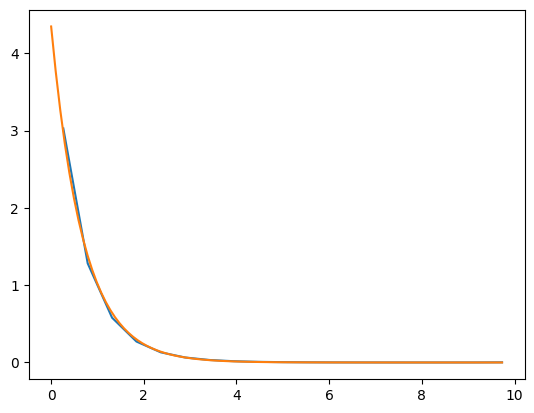

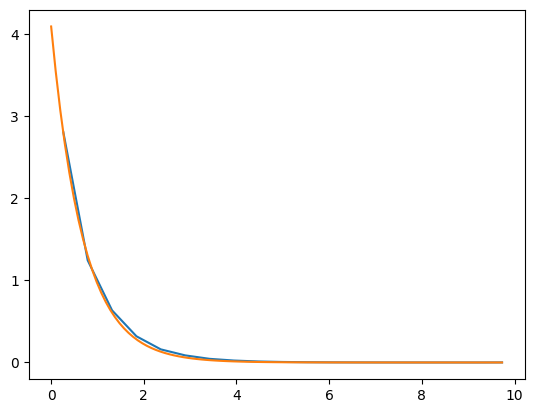

1.4543697399542759 0.004517288044425503 0.05981512513295541
gamF/gamS =  13.241379461460166


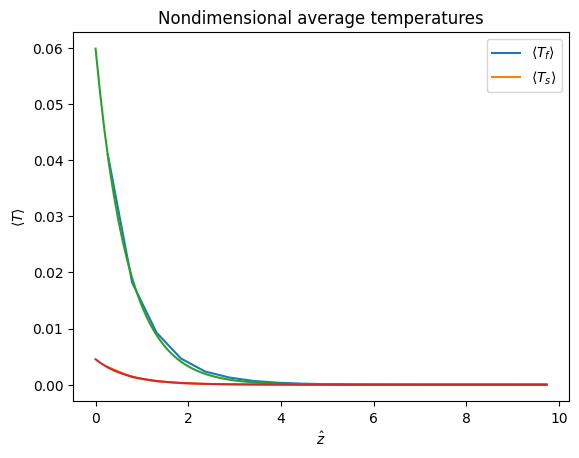

In [ ]:
    
z_nondim, TsolidNondim, TfluidNondim = nondimensionalize(resP15Re50)
# These are the averages on each media. I want the section average from VAT:
_, _, _, _, _, _, _, _, _, parameters = resP15Re50
_, _, _, _, epsi, _, _, _, _, _, _ = parameters 

TsolidNondim = (1-epsi)*np.array(TsolidNondim)
TfluidNondim = epsi*np.array(TfluidNondim)

zcutoff0 = 0.1
lam, gamS, gamF = adjust_to_exponential_coupled(z_nondim, TsolidNondim, TfluidNondim, zcutoff0)

print("gamF/gamS = ", gamF/gamS)

z_centers = [(z_nondim[i] + z_nondim[i+1])/2.0 for i in range(0,len(z_nondim)-1)]
plt.plot(z_centers, TfluidNondim, label=r"$\langle T_f \rangle$")
plt.plot(z_centers, TsolidNondim, label=r"$\langle T_s \rangle$")
zdotsplot = np.linspace(0,max(z_centers),100)
plt.plot(zdotsplot,[gamF*np.exp(-lam*z) for z in zdotsplot])
plt.plot(zdotsplot,[gamS*np.exp(-lam*z) for z in zdotsplot])
plt.title(r"Nondimensional average temperatures")
plt.xlabel(r"$\hat{z}$")
plt.ylabel(r"$\langle T \rangle$")
plt.legend()
plt.show()

In [ ]:

resP15Re10 = get_radial_Tprofile('Catalyst_P-0.15_n-7_nl-2_Re-10_InletModified/', '14.99990320535', num_zdots, num_rdots, sizeRfilter, field='T')


1.19 1004.9 7800.0 510.0 0.15
Minimum Z coordinate of the porous media:  -0.0499679912501
Maximum Z coordinate of the porous media:  0.0499679892031


Solid
2.33007555838928 0.6182982756166633


/tmp/ipykernel_3529/491858552.py:248: RuntimeWarning: invalid value encountered in log
  yvals = np.log(TNondim)


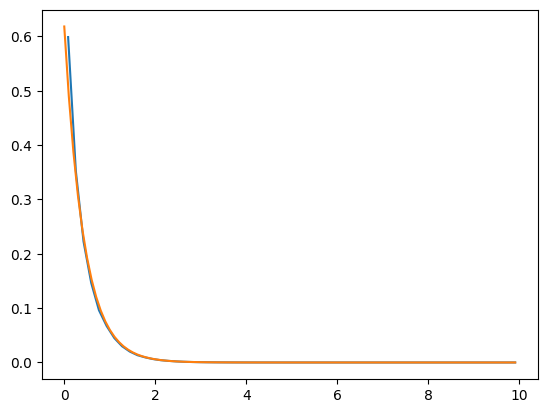

Fluid
2.3040019568179595 0.15266348089428536


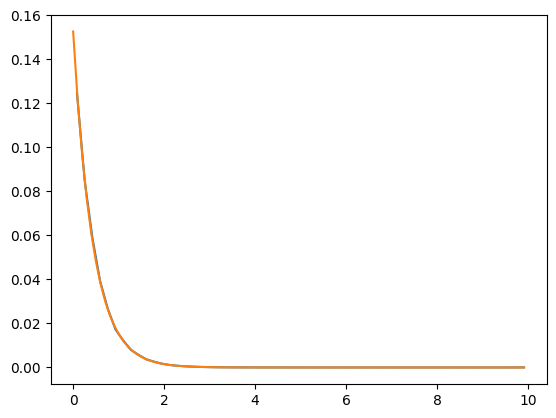

/tmp/ipykernel_3529/848529215.py:21: RuntimeWarning: invalid value encountered in log
  plt.plot(z_centers[0:l], [np.log(TfluidNondim[i]) for i in range(0,l)], label=r"$\langle T_f \rangle$")
/tmp/ipykernel_3529/848529215.py:22: RuntimeWarning: invalid value encountered in log
  plt.plot(z_centers[0:l], [np.log(TsolidNondim[i]) for i in range(0,l)], label=r"$\langle T_s \rangle$")


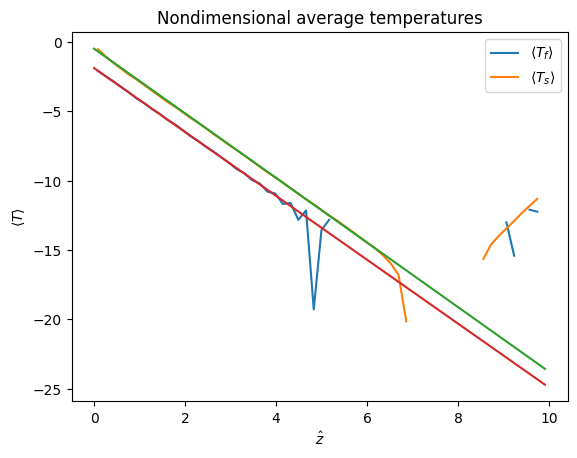

In [ ]:
z_nondim, TsolidNondim, TfluidNondim = nondimensionalize(resP15Re10)
# These are the averages on each media. I want the section average from VAT:
_, _, _, _, _, _, _, _, _, parameters = resP15Re10
_, _, _, _, epsi, _, R, _, _, _, _, Rchannels = parameters 

TsolidNondim = (1-epsi)*np.array(TsolidNondim)
TfluidNondim = epsi*np.array(TfluidNondim)

zmin = 3.0
zmax = 6.5
print("Solid")
lams, gams = adjust_to_exponential(z_nondim, TsolidNondim, zmin, zmax)
zmin = 1.5
zmax = 4.0
print("Fluid")
lamf, gamf = adjust_to_exponential(z_nondim, TfluidNondim, zmin, zmax)

#print("gamF/gamS = ", gamF/gamS)
l=len(z_centers)-1
z_centers = [(z_nondim[i] + z_nondim[i+1])/2.0 for i in range(0,len(z_nondim)-1)]
plt.plot(z_centers[0:l], [np.log(TfluidNondim[i]) for i in range(0,l)], label=r"$\langle T_f \rangle$")
plt.plot(z_centers[0:l], [np.log(TsolidNondim[i]) for i in range(0,l)], label=r"$\langle T_s \rangle$")
zdotsplot = np.linspace(0,max(z_centers),100)
plt.plot(zdotsplot,[-lams*z + np.log(gams) for z in zdotsplot])
plt.plot(zdotsplot,[-lamf*z + np.log(gamf) for z in zdotsplot])
#plt.ylim([0.0,1.0])
plt.title(r"Nondimensional average temperatures")
plt.xlabel(r"$\hat{z}$")
plt.ylabel(r"$\langle T \rangle$")
plt.legend()
plt.show()

In [ ]:
resP15Re20 = get_radial_Tprofile('Catalyst_P-0.15_n-7_nl-2_Re-20_InletModified/', '14.9999970125', num_zdots, num_rdots, sizeRfilter, field='T')

1.19 1004.9 7800.0 510.0 0.15
Minimum Z coordinate of the porous media:  -0.0499679912501
Maximum Z coordinate of the porous media:  0.0499679892031


Solid
2.2947165643352663 0.5563748264978561


/tmp/ipykernel_3529/491858552.py:248: RuntimeWarning: invalid value encountered in log
  yvals = np.log(TNondim)


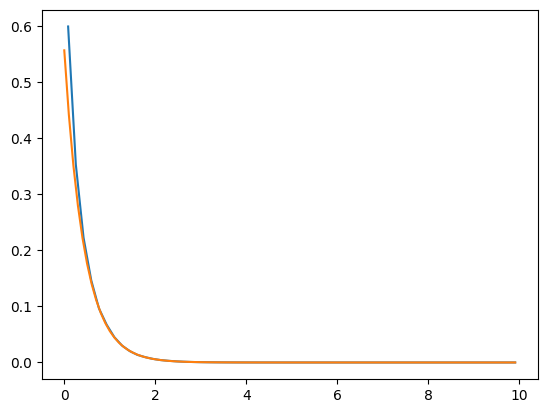

Fluid
2.090938733976283 0.17366890622058237


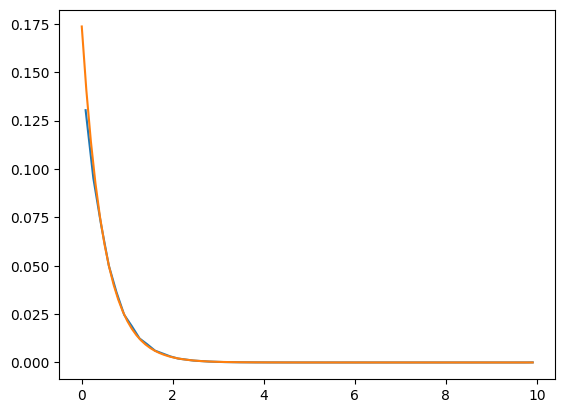

/tmp/ipykernel_3529/1012773432.py:21: RuntimeWarning: invalid value encountered in log
  plt.plot(z_centers[0:l], [np.log(TfluidNondim[i]) for i in range(0,l)], label=r"$\langle T_f \rangle$")
/tmp/ipykernel_3529/1012773432.py:22: RuntimeWarning: invalid value encountered in log
  plt.plot(z_centers[0:l], [np.log(TsolidNondim[i]) for i in range(0,l)], label=r"$\langle T_s \rangle$")


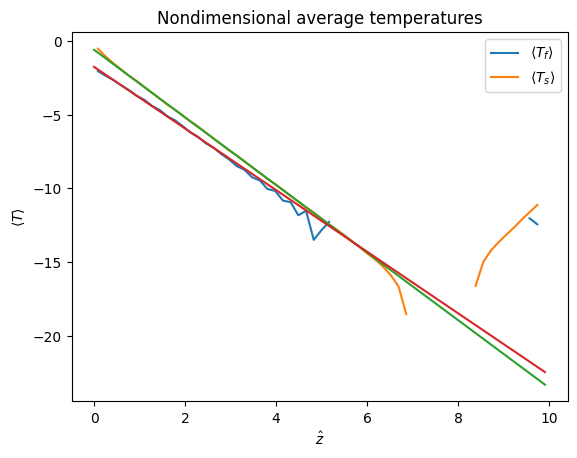

In [ ]:
z_nondim, TsolidNondim, TfluidNondim = nondimensionalize(resP15Re20)
# These are the averages on each media. I want the section average from VAT:
_, _, _, _, _, _, _, _, _, parameters = resP15Re20
_, _, _, _, epsi, _, R, _, _, _, _, Rchannels = parameters 

TsolidNondim = (1-epsi)*np.array(TsolidNondim)
TfluidNondim = epsi*np.array(TfluidNondim)

zmin = 1.0
zmax = 5.5
print("Solid")
lams, gams = adjust_to_exponential(z_nondim, TsolidNondim, zmin, zmax)
zmin = 0.0
zmax = 3.0
print("Fluid")
lamf, gamf = adjust_to_exponential(z_nondim, TfluidNondim, zmin, zmax)

#print("gamF/gamS = ", gamF/gamS)
l=len(z_centers)-1
z_centers = [(z_nondim[i] + z_nondim[i+1])/2.0 for i in range(0,len(z_nondim)-1)]
plt.plot(z_centers[0:l], [np.log(TfluidNondim[i]) for i in range(0,l)], label=r"$\langle T_f \rangle$")
plt.plot(z_centers[0:l], [np.log(TsolidNondim[i]) for i in range(0,l)], label=r"$\langle T_s \rangle$")
zdotsplot = np.linspace(0,max(z_centers),100)
plt.plot(zdotsplot,[-lams*z + np.log(gams) for z in zdotsplot])
plt.plot(zdotsplot,[-lamf*z + np.log(gamf) for z in zdotsplot])
#plt.ylim([0.0,1.0])
plt.title(r"Nondimensional average temperatures")
plt.xlabel(r"$\hat{z}$")
plt.ylabel(r"$\langle T \rangle$")
plt.legend()
plt.show()

In [ ]:
resP15Re30 = get_radial_Tprofile('Catalyst_P-0.15_n-7_nl-2_Re-30_InletModified/', '15.000029004', num_zdots, num_rdots, sizeRfilter, field='T')

1.19 1004.9 7800.0 510.0 0.15
Minimum Z coordinate of the porous media:  -0.0499679912501
Maximum Z coordinate of the porous media:  0.0499679892031


Solid
2.2207613087077283 0.46359492894879184


/tmp/ipykernel_3529/491858552.py:248: RuntimeWarning: invalid value encountered in log
  yvals = np.log(TNondim)


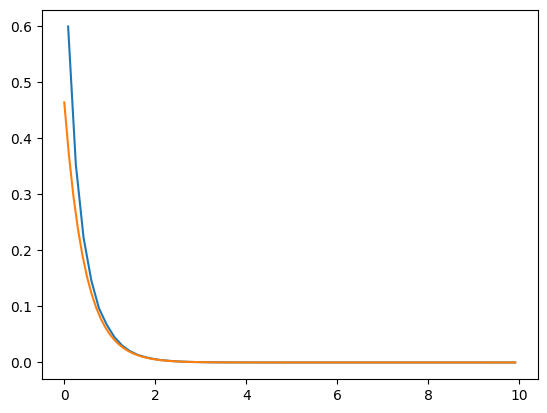

Fluid
1.8565629771867616 0.18415771964128264


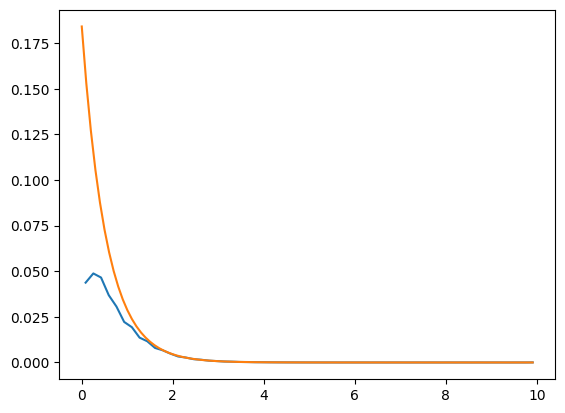

/tmp/ipykernel_3529/1739037858.py:21: RuntimeWarning: invalid value encountered in log
  plt.plot(z_centers[0:l], [np.log(TfluidNondim[i]) for i in range(0,l)], label=r"$\langle T_f \rangle$")
/tmp/ipykernel_3529/1739037858.py:22: RuntimeWarning: invalid value encountered in log
  plt.plot(z_centers[0:l], [np.log(TsolidNondim[i]) for i in range(0,l)], label=r"$\langle T_s \rangle$")


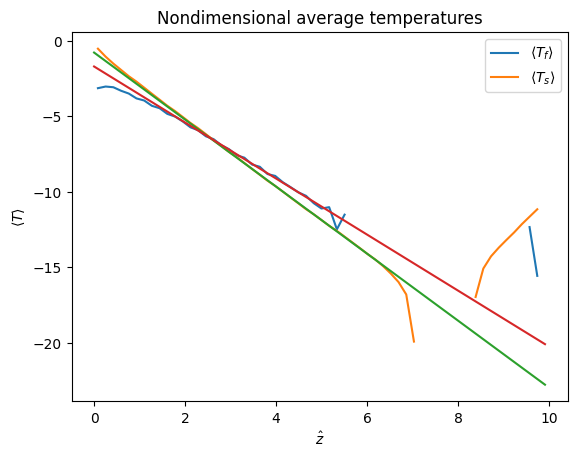

In [ ]:
z_nondim, TsolidNondim, TfluidNondim = nondimensionalize(resP15Re30)
# These are the averages on each media. I want the section average from VAT:
_, _, _, _, _, _, _, _, _, parameters = resP15Re30
_, _, _, _, epsi, _, R, _, _, _, _, Rchannels = parameters 

TsolidNondim = (1-epsi)*np.array(TsolidNondim)
TfluidNondim = epsi*(np.array(TfluidNondim)-np.array(TsolidNondim))

zmin = 3.0
zmax = 6.5
print("Solid")
lams, gams = adjust_to_exponential(z_nondim, TsolidNondim, zmin, zmax)
zmin = 2.0
zmax = 5.0
print("Fluid")
lamf, gamf = adjust_to_exponential(z_nondim, TfluidNondim, zmin, zmax)

#print("gamF/gamS = ", gamF/gamS)
l=len(z_centers)-1
z_centers = [(z_nondim[i] + z_nondim[i+1])/2.0 for i in range(0,len(z_nondim)-1)]
plt.plot(z_centers[0:l], [np.log(TfluidNondim[i]) for i in range(0,l)], label=r"$\langle T_f \rangle$")
plt.plot(z_centers[0:l], [np.log(TsolidNondim[i]) for i in range(0,l)], label=r"$\langle T_s \rangle$")
zdotsplot = np.linspace(0,max(z_centers),100)
plt.plot(zdotsplot,[-lams*z + np.log(gams) for z in zdotsplot])
plt.plot(zdotsplot,[-lamf*z + np.log(gamf) for z in zdotsplot])
#plt.ylim([0.0,1.0])
plt.title(r"Nondimensional average temperatures")
plt.xlabel(r"$\hat{z}$")
plt.ylabel(r"$\langle T \rangle$")
plt.legend()
plt.show()

In [ ]:
resP15Re40t15 = get_radial_Tprofile('Catalyst_P-0.15_n-7_nl-2_Re-40_InletModified/', '14.99997509357', num_zdots, num_rdots, sizeRfilter, field='T')
resP15Re40t12 = get_radial_Tprofile('Catalyst_P-0.15_n-7_nl-2_Re-40_InletModified/', '12.000024516', num_zdots, num_rdots, sizeRfilter, field='T')
resP15Re40t09 = get_radial_Tprofile('Catalyst_P-0.15_n-7_nl-2_Re-40_InletModified/', '9.00001839', num_zdots, num_rdots, sizeRfilter, field='T')
resP15Re40t06 = get_radial_Tprofile('Catalyst_P-0.15_n-7_nl-2_Re-40_InletModified/', '6.0000123', num_zdots, num_rdots, sizeRfilter, field='T')
resP15Re40t03 = get_radial_Tprofile('Catalyst_P-0.15_n-7_nl-2_Re-40_InletModified/', '3.000006', num_zdots, num_rdots, sizeRfilter, field='T')

1.19 1004.9 7800.0 510.0 0.15
Minimum Z coordinate of the porous media:  -0.0499679912501
Maximum Z coordinate of the porous media:  0.0499679892031
1.19 1004.9 7800.0 510.0 0.15
Minimum Z coordinate of the porous media:  -0.0499679912501
Maximum Z coordinate of the porous media:  0.0499679892031
1.19 1004.9 7800.0 510.0 0.15
Minimum Z coordinate of the porous media:  -0.0499679912501
Maximum Z coordinate of the porous media:  0.0499679892031
1.19 1004.9 7800.0 510.0 0.15
Minimum Z coordinate of the porous media:  -0.0499679912501
Maximum Z coordinate of the porous media:  0.0499679892031
1.19 1004.9 7800.0 510.0 0.15
Minimum Z coordinate of the porous media:  -0.0499679912501
Maximum Z coordinate of the porous media:  0.0499679892031


/tmp/ipykernel_3334/381514600.py:248: RuntimeWarning: invalid value encountered in log
  yvals = np.log(TNondim)


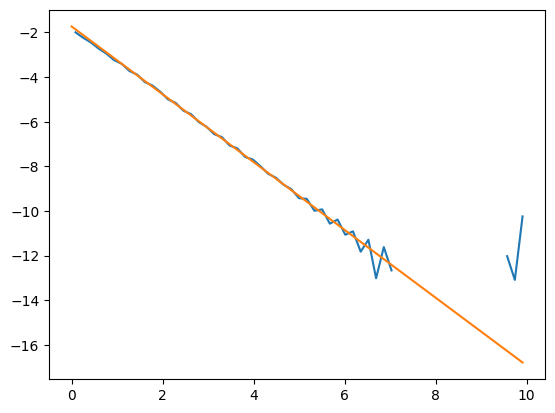

1.5187365742709897 0.17623958975470325


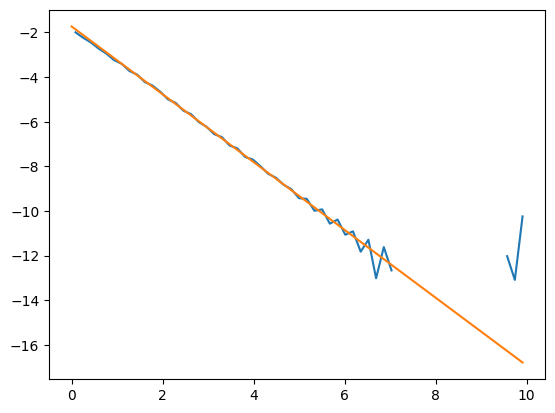

1.5187365742709897 0.17623958975470325


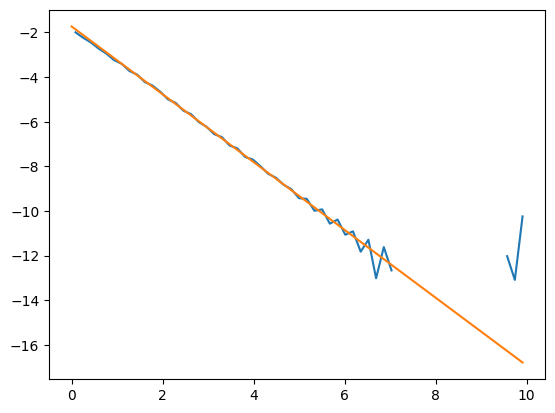

1.5187365742709897 0.17623958975470325


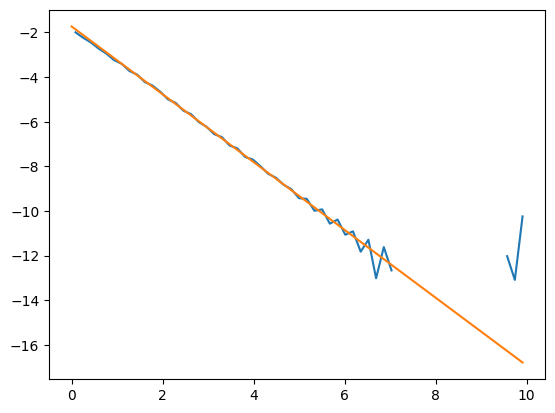

1.5187365742709897 0.17623958975470325


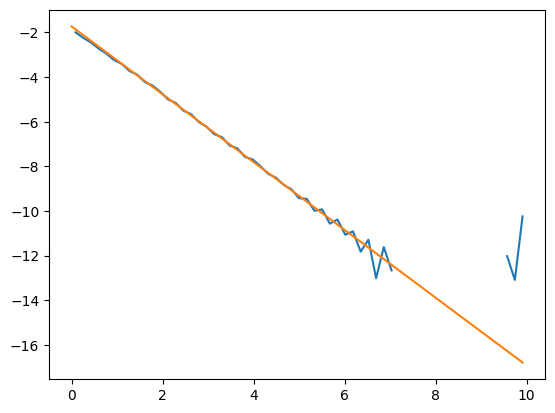

1.5187359127241489 0.1762401051995703
1.5187365742709897 0.17623958975470325


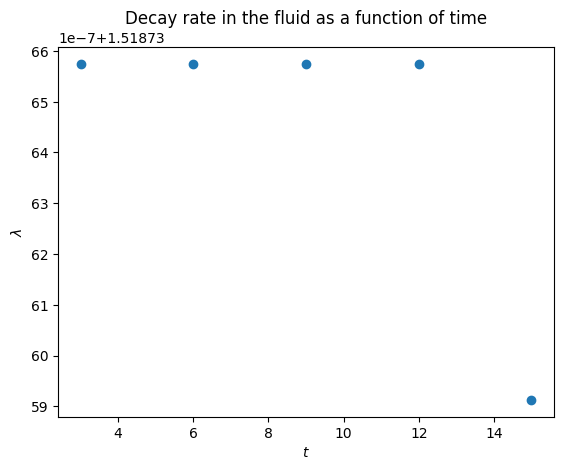

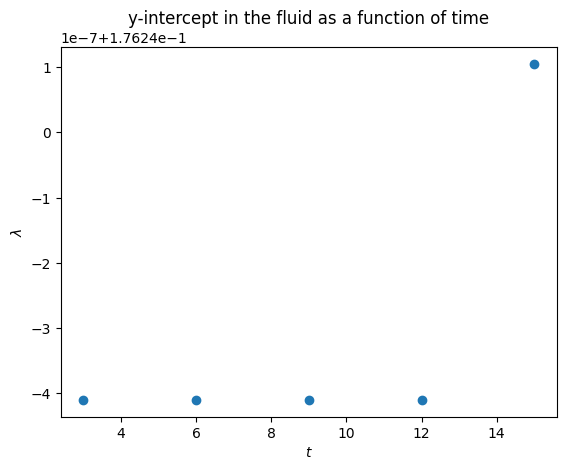

In [ ]:
z_nondim154015, TsolidNondim154015, TfluidNondim154015 = nondimensionalize(resP15Re40t15)
z_nondim154012, TsolidNondim154012, TfluidNondim154012 = nondimensionalize(resP15Re40t12)
z_nondim154009, TsolidNondim154009, TfluidNondim154009 = nondimensionalize(resP15Re40t09)
z_nondim154006, TsolidNondim154006, TfluidNondim154006 = nondimensionalize(resP15Re40t06)
z_nondim154003, TsolidNondim154003, TfluidNondim154003 = nondimensionalize(resP15Re40t03)

# Same values for all these cases:
_, _, _, _, _, _, _, _, _, parameters = resP15Re40t15
_, _, _, _, epsi, _, R, _, _, _, _, Rchannels = parameters 

# Decay rate in the fluid for different times:
zmin = 2.0
zmax = 5.0
lamf15, gamf15 = adjust_to_exponential(z_nondim, epsi*np.array(TfluidNondim154015), zmin, zmax)
lamf12, gamf12 = adjust_to_exponential(z_nondim, epsi*np.array(TfluidNondim154012), zmin, zmax)
lamf09, gamf09 = adjust_to_exponential(z_nondim, epsi*np.array(TfluidNondim154009), zmin, zmax)
lamf06, gamf06 = adjust_to_exponential(z_nondim, epsi*np.array(TfluidNondim154006), zmin, zmax)
lamf03, gamf03 = adjust_to_exponential(z_nondim, epsi*np.array(TfluidNondim154003), zmin, zmax)
print(lamf15, gamf15)

plt.scatter([3.0,6.0,9.0,12.0,15.0],[lamf15,lamf12,lamf09,lamf06,lamf03])
plt.title("Decay rate in the fluid as a function of time")
plt.xlabel(r"$t$")
plt.ylabel(r"$\lambda$")
plt.show()

plt.scatter([3.0,6.0,9.0,12.0,15.0],[gamf15,gamf12,gamf09,gamf06,gamf03])
plt.title("y-intercept in the fluid as a function of time")
plt.xlabel(r"$t$")
plt.ylabel(r"$\lambda$")
plt.show()

Solid
2.125838783336102 0.41279795977615313


/tmp/ipykernel_3334/3018665657.py:248: RuntimeWarning: invalid value encountered in log
  yvals = np.log(TNondim)


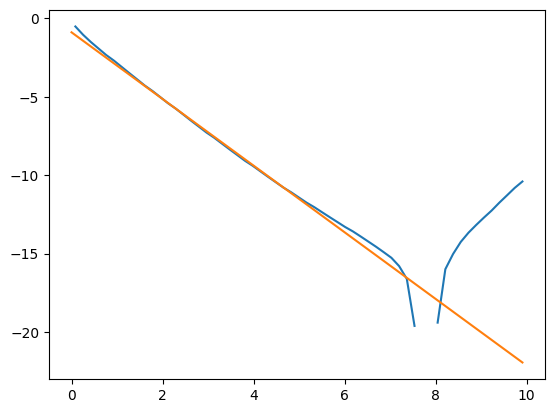

Fluid
1.5187365742709897 0.17623958975470325


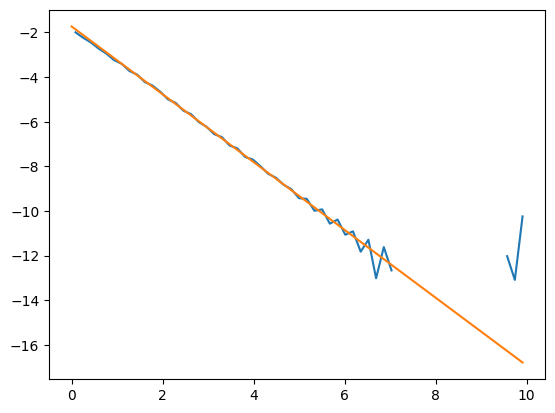

/tmp/ipykernel_3334/3461404002.py:21: RuntimeWarning: invalid value encountered in log
  plt.plot(z_centers[0:l], [np.log(TfluidNondim[i]) for i in range(0,l)], label=r"$\langle T_f \rangle$")
/tmp/ipykernel_3334/3461404002.py:22: RuntimeWarning: invalid value encountered in log
  plt.plot(z_centers[0:l], [np.log(TsolidNondim[i]) for i in range(0,l)], label=r"$\langle T_s \rangle$")


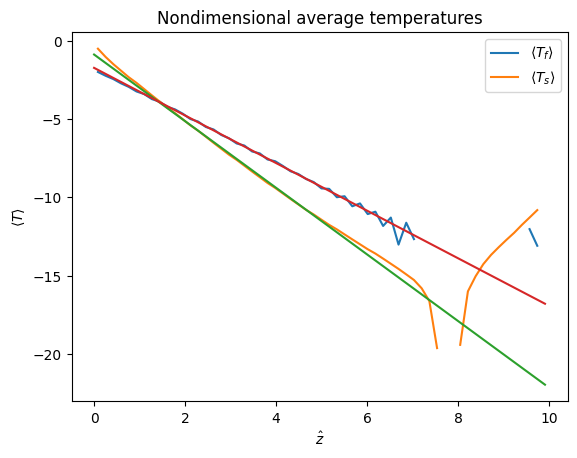

In [ ]:
z_nondim, TsolidNondim, TfluidNondim = nondimensionalize(resP15Re40)
# These are the averages on each media. I want the section average from VAT:
_, _, _, _, _, _, _, _, _, parameters = resP15Re40
_, _, _, _, epsi, _, R, _, _, _, _, Rchannels = parameters 

TsolidNondim = (1-epsi)*np.array(TsolidNondim)
TfluidNondim = epsi*np.array(TfluidNondim)

zmin = 1.0
zmax = 5.5
print("Solid")
lams, gams = adjust_to_exponential(z_nondim, TsolidNondim, zmin, zmax)
zmin = 2.0
zmax = 5.0
print("Fluid")
lamf, gamf = adjust_to_exponential(z_nondim, TfluidNondim, zmin, zmax)

#print("gamF/gamS = ", gamF/gamS)
z_centers = [(z_nondim[i] + z_nondim[i+1])/2.0 for i in range(0,len(z_nondim)-1)]
l=len(z_centers)-1
plt.plot(z_centers[0:l], [np.log(TfluidNondim[i]) for i in range(0,l)], label=r"$\langle T_f \rangle$")
plt.plot(z_centers[0:l], [np.log(TsolidNondim[i]) for i in range(0,l)], label=r"$\langle T_s \rangle$")
zdotsplot = np.linspace(0,max(z_centers),100)
plt.plot(zdotsplot,[-lams*z + np.log(gams) for z in zdotsplot])
plt.plot(zdotsplot,[-lamf*z + np.log(gamf) for z in zdotsplot])
#plt.ylim([0.0,1.0])
plt.title(r"Nondimensional average temperatures")
plt.xlabel(r"$\hat{z}$")
plt.ylabel(r"$\langle T \rangle$")
plt.legend()
plt.show()

### Results

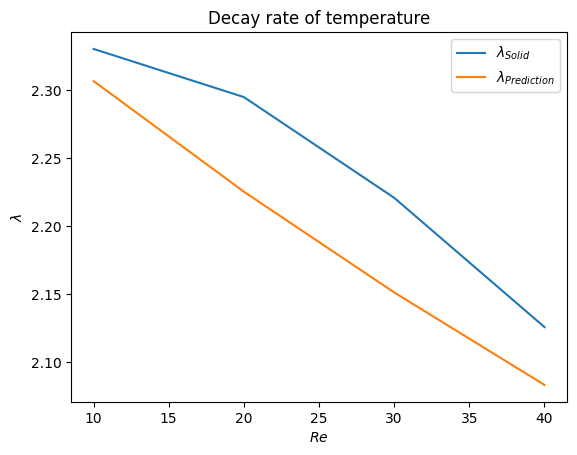

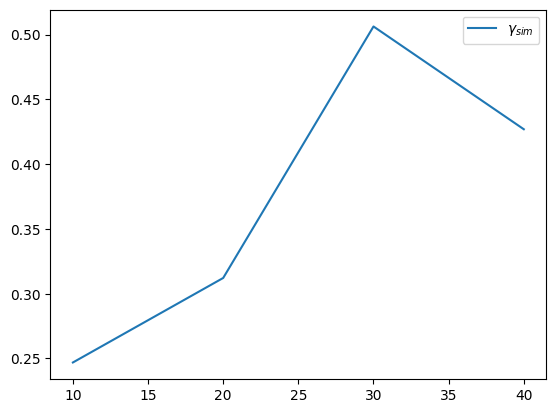

In [ ]:
# [lambdaS, lambdaF, gammaS, gammaF, lambdaPrediction, gammaPrediction, Rep]
#resP15Re10 = [2.341044625481439, 2.2979291976752143, 0.5879635599077833, 0.15314134593886908, 2.306456526922641, 5.81979399061473, 10]
resP15Re10 = [2.33007555838928, 2.3040019568179595, 0.6182982756166633, 0.15266348089428536, 2.306456526922641, 5.81979399061473, 10]

#resP15Re20 = [2.3315282311030048, 1.9582844916247797, 0.5848338665966607, 0.15907080827372683, 2.225244537202592, 5.638604281646472, 20]
resP15Re20 = [2.2947165643352663, 2.090938733976283, 0.5563748264978561, 0.17366890622058237, 2.225244537202592, 5.638604281646472, 20] 

#resP15Re30 = [2.315721687984573, 1.6652393645248782, 0.5776899746918596, 0.15773439272150627, 2.1512712077323575, 5.479216221959543, 30]
resP15Re30 = [2.2207613087077283, 1.8953600731628386, 0.46359492894879184, 0.2347010155100244, 2.1512712077323575, 5.479216221959543, 30]

#resP15Re40 = [2.2955756053025014, 1.4383572086128813, 0.5675487779667308, 0.15483628408399908, 2.083370385771236, 5.337655159641572, 40]
resP15Re40 = [2.125838783336102, 1.5187365742709897, 0.41279795977615313, 0.17623958975470325, 2.083370385771236, 5.337655159641572, 40]

plt.plot([resP15Re10[6],resP15Re20[6],resP15Re30[6], resP15Re40[6]],[resP15Re10[0],resP15Re20[0],resP15Re30[0], resP15Re40[0]], label=r"$\lambda_{Solid}$")
#plt.plot([resP15Re10[6],resP15Re20[6],resP15Re30[6], resP15Re40[6]],[resP15Re10[1],resP15Re20[1],resP15Re30[1], resP15Re40[1]], label=r"$\lambda_{Fluid}$")
plt.plot([resP15Re10[6],resP15Re20[6],resP15Re30[6], resP15Re40[6]],[resP15Re10[4],resP15Re20[4],resP15Re30[4], resP15Re40[4]], label=r"$\lambda_{Prediction}$")
plt.legend()
plt.xlabel(r"$Re$")
plt.ylabel(r"$\lambda$")
plt.title(r"Decay rate of temperature")
plt.show()

plt.plot([resP15Re10[6],resP15Re20[6],resP15Re30[6], resP15Re40[6]],[resP15Re10[3]/resP15Re10[2], resP15Re20[3]/resP15Re20[2], resP15Re30[3]/resP15Re30[2], resP15Re40[3]/resP15Re40[2]], label=r"$\gamma_{sim}$")
#plt.plot([resP15Re10[6],resP15Re20[6],resP15Re30[6], resP15Re40[6]],[resP15Re10[5], resP15Re20[5], resP15Re30[5], resP15Re40[5]], label=r"$\gamma_{Prediction}$")
plt.legend()
plt.show()
 
  




## Analysis for different configurations

In [ ]:
sizeZfilter = 0.004
num_zdots = 200
resP25Re10t15_CONF1 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-10_CONF1_InletModified/', '15.000094504', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re10t15_CONF2 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-10_CONF2_InletModified/', '14.99989971903', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re10t15_CONF3 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-3_Re-10_CONF3_InletModified/', '14.99990395', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')

1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499619926258
Maximum Z coordinate of the porous media:  0.0499619947756
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499759125036
Maximum Z coordinate of the porous media:  0.0499759125045
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.049978123574
Maximum Z coordinate of the porous media:  0.0499781250229


In [ ]:
sizeZfilter = 0.004
num_zdots = 200
resP25Re20t15_CONF1 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-20_CONF1_InletModified/', '15.0000466751', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re20t15_CONF2 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-20_CONF2_InletModified/', '15.00000652573', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re20t15_CONF3 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-3_Re-20_CONF3_InletModified/', '14.99994522041', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')

1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499619926258
Maximum Z coordinate of the porous media:  0.0499619947756
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499759125036
Maximum Z coordinate of the porous media:  0.0499759125045
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.049978123574
Maximum Z coordinate of the porous media:  0.0499781250229


In [ ]:
sizeZfilter = 0.004
num_zdots = 200
resP25Re30t15_CONF1 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-30_CONF1_InletModified/', '15.00001419', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re30t15_CONF2 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-30_CONF2_InletModified/', '15.000086037', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re30t15_CONF3 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-3_Re-30_CONF3_InletModified/', '14.999993359', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')

1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499619926258
Maximum Z coordinate of the porous media:  0.0499619947756
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499759125036
Maximum Z coordinate of the porous media:  0.0499759125045
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.049978123574
Maximum Z coordinate of the porous media:  0.0499781250229


In [ ]:
sizeZfilter = 0.004
num_zdots = 200

resP25Re40t15_CONF1 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-40_CONF1_InletModified/', '15.0000168556', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re40t15_CONF2 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-40_CONF2_InletModified/', '15.00001596', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re40t15_CONF3 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-3_Re-40_CONF3_InletModified/', '14.99999453194', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')

1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499619926258
Maximum Z coordinate of the porous media:  0.0499619947756
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499759125036
Maximum Z coordinate of the porous media:  0.0499759125045
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.049978123574
Maximum Z coordinate of the porous media:  0.0499781250229


In [ ]:
sizeZfilter = 0.004
num_zdots = 200

resP25Re50t15_CONF1 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-50_CONF1_InletModified/', '14.999996178', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re50t15_CONF2 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-50_CONF2_InletModified/', '14.99999291', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re50t15_CONF3 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-3_Re-50_CONF3_InletModified/', '14.9999798358', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')

1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499619926258
Maximum Z coordinate of the porous media:  0.0499619947756
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499759125036
Maximum Z coordinate of the porous media:  0.0499759125045
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.049978123574
Maximum Z coordinate of the porous media:  0.0499781250229


In [ ]:
sizeZfilter = 0.004
num_zdots = 200

resP25Re60t15_CONF1 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-60_CONF1_InletModified/', '15.00000159291', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re60t15_CONF2 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-60_CONF2_InletModified/', '14.9999855771', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re60t15_CONF3 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-3_Re-60_CONF3_InletModified/', '14.9999965279', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')

1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499619926258
Maximum Z coordinate of the porous media:  0.0499619947756
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499759125036
Maximum Z coordinate of the porous media:  0.0499759125045
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.049978123574
Maximum Z coordinate of the porous media:  0.0499781250229


In [ ]:
sizeZfilter = 0.004
num_zdots = 200

resP25Re70t15_CONF1 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-70_CONF1_InletModified/', '15.0000126679', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re70t15_CONF2 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-70_CONF2_InletModified/', '14.9999973387', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re70t15_CONF3 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-3_Re-70_CONF3_InletModified/', '15.00001224963', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')

1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499619926258
Maximum Z coordinate of the porous media:  0.0499619947756
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499759125036
Maximum Z coordinate of the porous media:  0.0499759125045
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.049978123574
Maximum Z coordinate of the porous media:  0.0499781250229


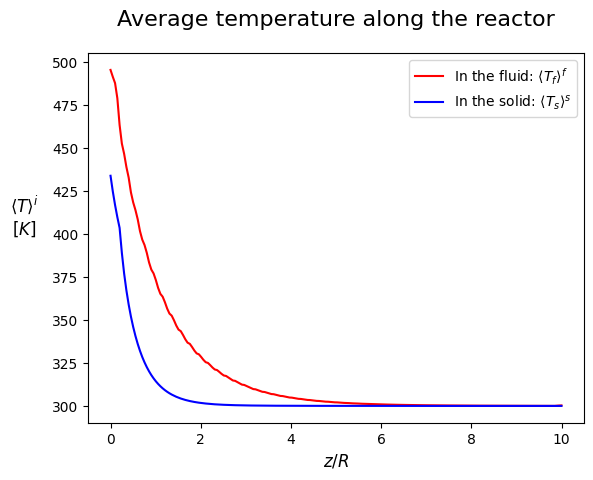

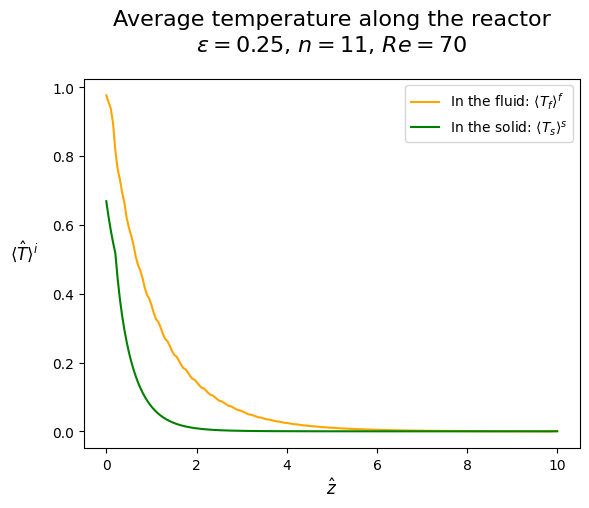

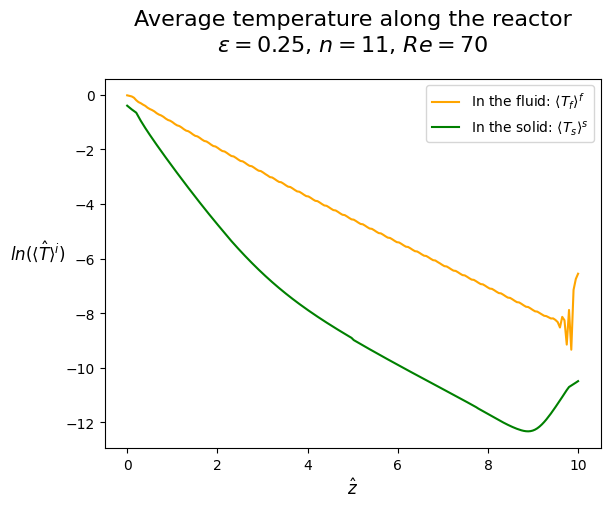

In [ ]:
import matplotlib.pyplot as plt
# Graphs for the presentation:
TavgSec, TavgSecFluid, TavgSecSolid, zdots, KavSec, parameters = resP25Re70t15_CONF2
fluidRho, fluidCp, solidRho, solidCp, porosity, wallTemp, R, FluidPr, SolidK, fluidMU, inletTemp, Rchannels = parameters

plt.plot(np.array([(z-zdots[0])/R for z in zdots]), TavgSecFluid, color="red", label=r"In the fluid: $\langle T_f \rangle^f$")
plt.plot(np.array([(z-zdots[0])/R for z in zdots]), TavgSecSolid, color="blue", label=r"In the solid: $\langle T_s \rangle^s$")
plt.title(r"Average temperature along the reactor", fontsize = 16, pad=20)
plt.legend()
plt.xlabel(r"$z/R$", fontsize = 12)
plt.ylabel( r"$\langle T \rangle^i$"
            "\n"
            r"$\left[ K \right]$", rotation='horizontal', fontsize = 12, labelpad=20)
#plt.xlim(0,33)
plt.show()

z_nondim257015_CONF2, TsolidNondim257015_CONF2, TfluidNondim257015_CONF2 = nondimensionalize(resP25Re70t15_CONF2)

plt.plot(z_nondim257015_CONF2, TfluidNondim257015_CONF2, color="orange", label=r"In the fluid: $\langle T_f \rangle^f$")
plt.plot(z_nondim257015_CONF2, TsolidNondim257015_CONF2, color="green", label=r"In the solid: $\langle T_s \rangle^s$")
plt.title(r"Average temperature along the reactor"
            "\n"
            r"$\varepsilon = 0.25$, $n=11$, $Re = 70$", fontsize = 16, pad=20)
plt.legend()
plt.xlabel(r"$\hat{z}$", fontsize = 12)
plt.ylabel( r"$\langle \hat{T} \rangle^i$", rotation='horizontal', fontsize = 12, labelpad=20)
#plt.xlim(0,33)
plt.show()

plt.plot(z_nondim257015_CONF2, np.log(TfluidNondim257015_CONF2), color="orange", label=r"In the fluid: $\langle T_f \rangle^f$")
plt.plot(z_nondim257015_CONF2, np.log(TsolidNondim257015_CONF2), color="green", label=r"In the solid: $\langle T_s \rangle^s$")
plt.title(r"Average temperature along the reactor"
            "\n"
            r"$\varepsilon = 0.25$, $n=11$, $Re = 70$", fontsize = 16, pad=20)
plt.legend()
plt.xlabel(r"$\hat{z}$", fontsize = 12)
plt.ylabel( r"$ln(\langle \hat{T} \rangle^i)$", rotation='horizontal', fontsize = 12, labelpad=20)
#plt.xlim(0,33)
plt.show()


In [ ]:
sizeZfilter = 0.004
num_zdots = 200


resP25Re80t15_CONF1 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-80_CONF1_InletModified/', '14.9999899889', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re80t15_CONF2 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-80_CONF2_InletModified/', '15.000009318', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re80t15_CONF3 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-3_Re-80_CONF3_InletModified/', '14.999995258', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')

1.19 1004.9 7800.0 510.0 0.25


/home/pablo/Projects/anaconda3/envs/OpenFoamPostProcessing/lib/python3.13/site-packages/Ofpp/mesh_parser.py:259: SyntaxWarning: invalid escape sequence '\d'
  return [[int(s) for s in re.findall(b"\d+", ln)[1:]] for ln in content[n + 2:n + 2 + num]]


KeyboardInterrupt: 

In [ ]:
sizeZfilter = 0.004
num_zdots = 200

resP25Re90t15_CONF1 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-90_CONF1_InletModified/', '14.99999318443', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re90t15_CONF2 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-90_CONF2_InletModified/', '15.00000759074', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re90t15_CONF3 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-3_Re-90_CONF3_InletModified/', '14.999998843', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')

1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499619926258
Maximum Z coordinate of the porous media:  0.0499619947756
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499759125036
Maximum Z coordinate of the porous media:  0.0499759125045
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.049978123574
Maximum Z coordinate of the porous media:  0.0499781250229


In [ ]:
sizeZfilter = 0.004
num_zdots = 200

resP25Re100t15_CONF1 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-100_CONF1_InletModified/', '14.9999985694', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re100t15_CONF2 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-2_Re-100_CONF2_InletModified/', '14.999997868', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')
resP25Re100t15_CONF3 = get_radial_Tprofile('Catalyst_P-0.25_n-11_nl-3_Re-100_CONF3_InletModified/', '14.9999940992', num_zdots, num_rdots, sizeRfilter, sizeZfilter, field='T')

1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499619926258
Maximum Z coordinate of the porous media:  0.0499619947756
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.0499759125036
Maximum Z coordinate of the porous media:  0.0499759125045
1.19 1004.9 7800.0 510.0 0.25
Minimum Z coordinate of the porous media:  -0.049978123574
Maximum Z coordinate of the porous media:  0.0499781250229


/tmp/ipykernel_10031/642430968.py:305: RuntimeWarning: invalid value encountered in log
  yvals = np.log(TNondim)
/tmp/ipykernel_10031/3795602658.py:19: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim251015_CONF1, np.log(TsolidNondim251015_CONF1),label="Solid conf 1")
/tmp/ipykernel_10031/3795602658.py:20: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim251015_CONF2, np.log(TsolidNondim251015_CONF2),label="Solid conf 2")
/tmp/ipykernel_10031/3795602658.py:21: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim251015_CONF3, np.log(TsolidNondim251015_CONF3),label="Solid conf 3")
/tmp/ipykernel_10031/3795602658.py:22: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim251015_CONF1, np.log(TfluidNondim251015_CONF1),label="Fluid conf 1",linestyle="dashed")
/tmp/ipykernel_10031/3795602658.py:23: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim251015_CONF2, np.log(TfluidNondim251015_CONF2),label="Fl

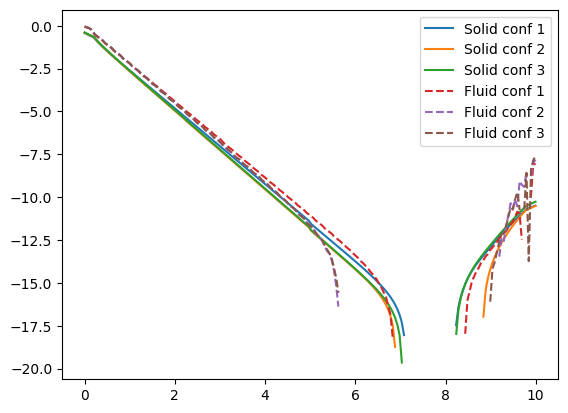

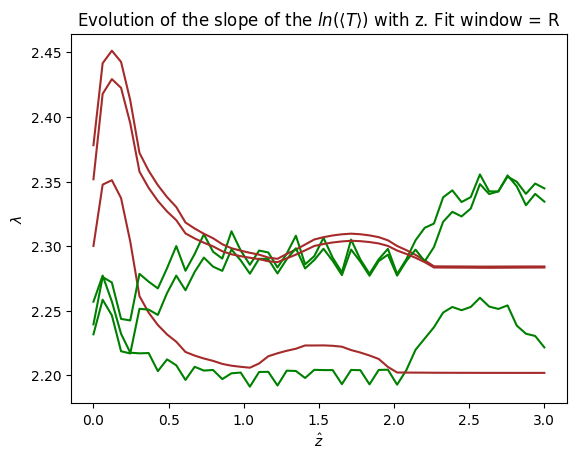

In [ ]:
# sAME FOR ALL CASES:
_, _, _, _, _, parameters = resP25Re10t15_CONF1
_, _, _, _, epsi, _, R, _, _, _, _, Rchannels = parameters 

zmin = 0.0
zmax = 4.0
z_nondim251015_CONF1, TsolidNondim251015_CONF1, TfluidNondim251015_CONF1 = nondimensionalize(resP25Re10t15_CONF1)
lamf2510_CONF1, gamf2510_CONF1 = adjust_to_exponential(z_nondim251015_CONF1, epsi*np.array(TfluidNondim251015_CONF1), zmin, zmax)
lams2510_CONF1, gams2510_CONF1 = adjust_to_exponential(z_nondim251015_CONF1, (1 - epsi)*np.array(TsolidNondim251015_CONF1), zmin, zmax)

z_nondim251015_CONF2, TsolidNondim251015_CONF2, TfluidNondim251015_CONF2 = nondimensionalize(resP25Re10t15_CONF2)
lamf2510_CONF2, gamf2510_CONF2 = adjust_to_exponential(z_nondim251015_CONF2, epsi*np.array(TfluidNondim251015_CONF2), zmin, zmax)
lams2510_CONF2, gams2510_CONF2 = adjust_to_exponential(z_nondim251015_CONF2, (1 - epsi)*np.array(TsolidNondim251015_CONF2), zmin, zmax)

z_nondim251015_CONF3, TsolidNondim251015_CONF3, TfluidNondim251015_CONF3 = nondimensionalize(resP25Re10t15_CONF3)
lamf2510_CONF3, gamf2510_CONF3 = adjust_to_exponential(z_nondim251015_CONF3, epsi*np.array(TfluidNondim251015_CONF3), zmin, zmax)
lams2510_CONF3, gams2510_CONF3 = adjust_to_exponential(z_nondim251015_CONF3, (1 - epsi)*np.array(TsolidNondim251015_CONF3), zmin, zmax)

plt.plot(z_nondim251015_CONF1, np.log(TsolidNondim251015_CONF1),label="Solid conf 1")
plt.plot(z_nondim251015_CONF2, np.log(TsolidNondim251015_CONF2),label="Solid conf 2")
plt.plot(z_nondim251015_CONF3, np.log(TsolidNondim251015_CONF3),label="Solid conf 3")
plt.plot(z_nondim251015_CONF1, np.log(TfluidNondim251015_CONF1),label="Fluid conf 1",linestyle="dashed")
plt.plot(z_nondim251015_CONF2, np.log(TfluidNondim251015_CONF2),label="Fluid conf 2",linestyle="dashed")
plt.plot(z_nondim251015_CONF3, np.log(TfluidNondim251015_CONF3),label="Fluid conf 3",linestyle="dashed")
plt.legend()
plt.show()

# Evolution of lamda:
zr_width = 1.0
zrange = np.linspace(zmin,zmax-zr_width,50)
lamfCONF1 = []
lamsCONF1 = []
lamfCONF2 = []
lamsCONF2 = []
lamfCONF3 = []
lamsCONF3 = []
for z in zrange:
    lf1, _ = adjust_to_exponential(z_nondim251015_CONF1, epsi*np.array(TfluidNondim251015_CONF1), z, z+zr_width)
    lamfCONF1.append(lf1)
    ls1, _ = adjust_to_exponential(z_nondim251015_CONF1, (1 - epsi)*np.array(TsolidNondim251015_CONF1), z, z+zr_width)
    lamsCONF1.append(ls1)
    lf2, _ = adjust_to_exponential(z_nondim251015_CONF2, epsi*np.array(TfluidNondim251015_CONF2), z, z+zr_width)
    lamfCONF2.append(lf2)
    ls2, _ = adjust_to_exponential(z_nondim251015_CONF2, (1 - epsi)*np.array(TsolidNondim251015_CONF2), z, z+zr_width)
    lamsCONF2.append(ls2)
    lf3, _ = adjust_to_exponential(z_nondim251015_CONF3, epsi*np.array(TfluidNondim251015_CONF3), z, z+zr_width)
    lamfCONF3.append(lf3)
    ls3, _ = adjust_to_exponential(z_nondim251015_CONF3, (1 - epsi)*np.array(TsolidNondim251015_CONF3), z, z+zr_width)
    lamsCONF3.append(ls3)

plt.plot(zrange, lamfCONF1, color="green")
plt.plot(zrange, lamsCONF1, color="brown")
plt.plot(zrange, lamfCONF2, color="green")
plt.plot(zrange, lamsCONF2, color="brown")
plt.plot(zrange, lamfCONF3, color="green")
plt.plot(zrange, lamsCONF3, color="brown")
plt.title(r"Evolution of the slope of the $ln(\langle T \rangle)$ with z. Fit window = R")
plt.xlabel(r"$\hat{z}$")
plt.ylabel(r"$\lambda$")
plt.show()

/tmp/ipykernel_7703/1253753347.py:305: RuntimeWarning: invalid value encountered in log
  yvals = np.log(TNondim)


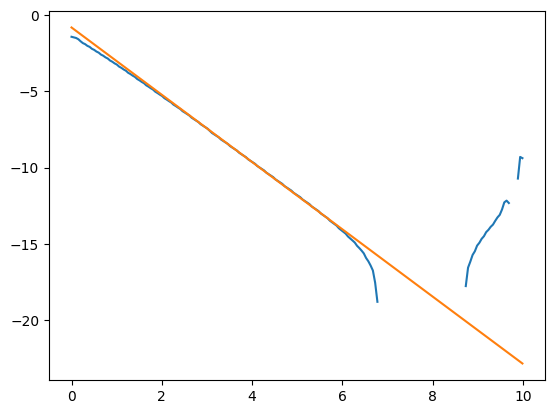

2.205879108203871 0.44430961039869166


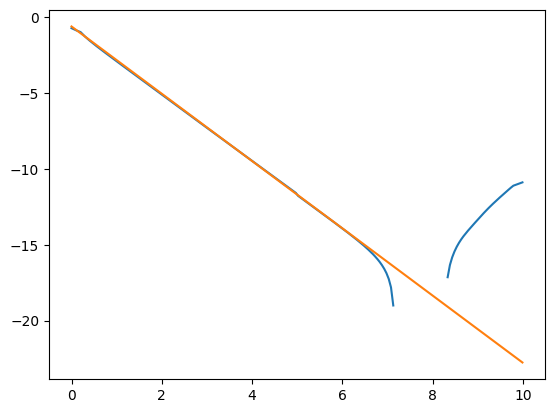

2.218332848269583 0.5499547090273353


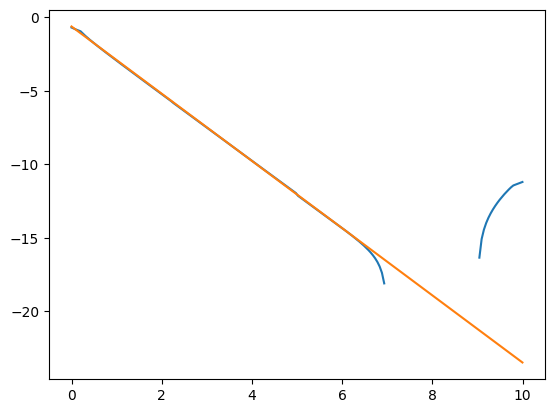

2.287668092813784 0.5380358583587808


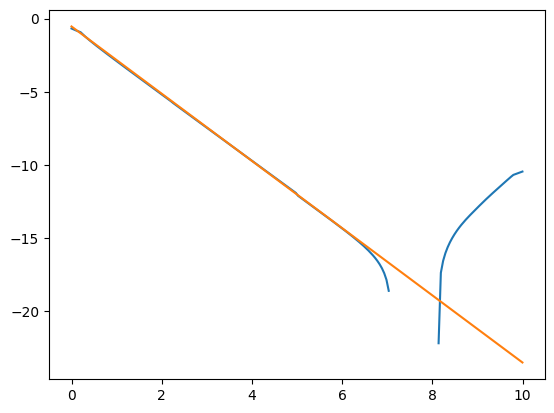

2.296801927056283 0.581775380765136


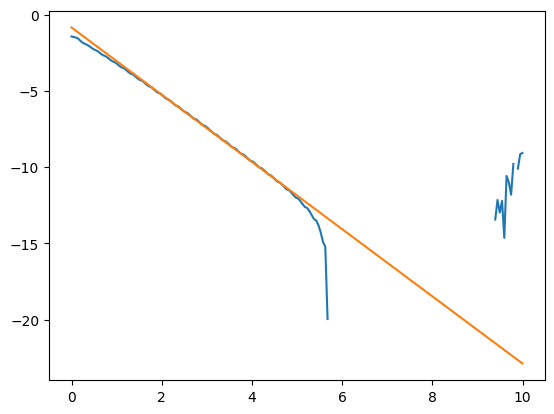

2.204904907937684 0.4332972338324992


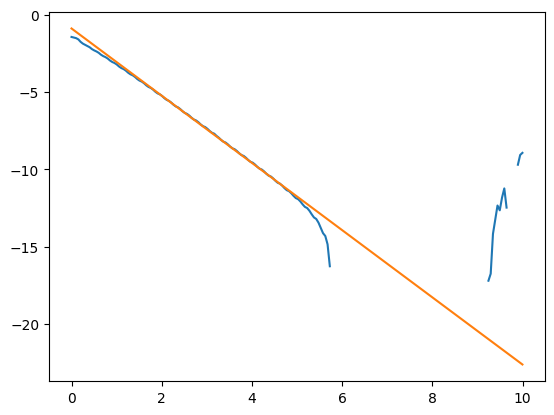

2.17452016711129 0.41522568995928644


/tmp/ipykernel_7703/1032951704.py:25: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim252015_CONF1, np.log(TsolidNondim252015_CONF1),label="Solid conf 1")
/tmp/ipykernel_7703/1032951704.py:26: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim252015_CONF2, np.log(TsolidNondim252015_CONF2),label="Solid conf 2")
/tmp/ipykernel_7703/1032951704.py:27: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim252015_CONF3, np.log(TsolidNondim252015_CONF3),label="Solid conf 3")
/tmp/ipykernel_7703/1032951704.py:28: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim252015_CONF1, np.log(TfluidNondim252015_CONF1),label="Fluid conf 1",linestyle="dashed")
/tmp/ipykernel_7703/1032951704.py:29: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim252015_CONF2, np.log(TfluidNondim252015_CONF2),label="Fluid conf 2",linestyle="dashed")
/tmp/ipykernel_7703/1032951704.py:30: RuntimeWarning: invalid value encountered in log


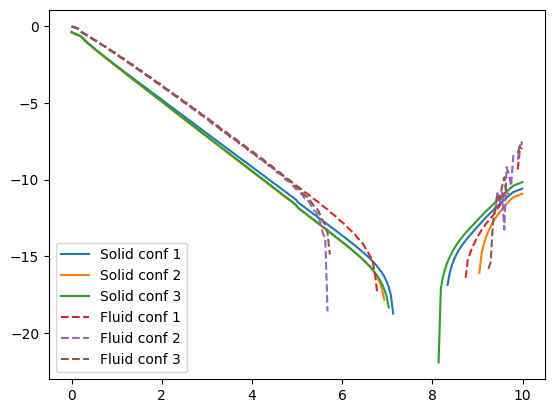

In [ ]:
# sAME FOR ALL CASES:
_, _, _, _, _, parameters = resP25Re20t15_CONF1
_, _, _, _, epsi, _, R, _, _, _, _, Rchannels = parameters 

zmin = 3.0
zmax = 6.0
z_nondim252015_CONF1, TsolidNondim252015_CONF1, TfluidNondim252015_CONF1 = nondimensionalize(resP25Re20t15_CONF1)
z_nondim252015_CONF2, TsolidNondim252015_CONF2, TfluidNondim252015_CONF2 = nondimensionalize(resP25Re20t15_CONF2)
z_nondim252015_CONF3, TsolidNondim252015_CONF3, TfluidNondim252015_CONF3 = nondimensionalize(resP25Re20t15_CONF3)

lamf2520_CONF1, gamf2520_CONF1 = adjust_to_exponential(z_nondim252015_CONF1, epsi*np.array(TfluidNondim252015_CONF1), zmin, zmax)
lams2520_CONF1, gams2520_CONF1 = adjust_to_exponential(z_nondim252015_CONF1, (1 - epsi)*np.array(TsolidNondim252015_CONF1), zmin, zmax)



lams2520_CONF2, gams2520_CONF2 = adjust_to_exponential(z_nondim252015_CONF2, (1 - epsi)*np.array(TsolidNondim252015_CONF2), zmin, zmax)
lams2520_CONF3, gams2520_CONF3 = adjust_to_exponential(z_nondim252015_CONF3, (1 - epsi)*np.array(TsolidNondim252015_CONF3), zmin, zmax)

zmin = 1.5
zmax = 5.0
lamf2520_CONF2, gamf2520_CONF2 = adjust_to_exponential(z_nondim252015_CONF2, epsi*np.array(TfluidNondim252015_CONF2), zmin, zmax)
lamf2520_CONF3, gamf2520_CONF3 = adjust_to_exponential(z_nondim252015_CONF3, epsi*np.array(TfluidNondim252015_CONF3), zmin, zmax)


plt.plot(z_nondim252015_CONF1, np.log(TsolidNondim252015_CONF1),label="Solid conf 1")
plt.plot(z_nondim252015_CONF2, np.log(TsolidNondim252015_CONF2),label="Solid conf 2")
plt.plot(z_nondim252015_CONF3, np.log(TsolidNondim252015_CONF3),label="Solid conf 3")
plt.plot(z_nondim252015_CONF1, np.log(TfluidNondim252015_CONF1),label="Fluid conf 1",linestyle="dashed")
plt.plot(z_nondim252015_CONF2, np.log(TfluidNondim252015_CONF2),label="Fluid conf 2",linestyle="dashed")
plt.plot(z_nondim252015_CONF3, np.log(TfluidNondim252015_CONF3),label="Fluid conf 3",linestyle="dashed")
plt.legend()
plt.show()

/tmp/ipykernel_7703/1253753347.py:305: RuntimeWarning: invalid value encountered in log
  yvals = np.log(TNondim)


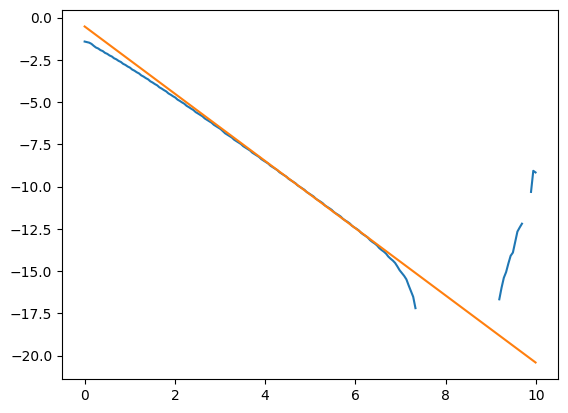

1.9902367638676601 0.5916369175743907


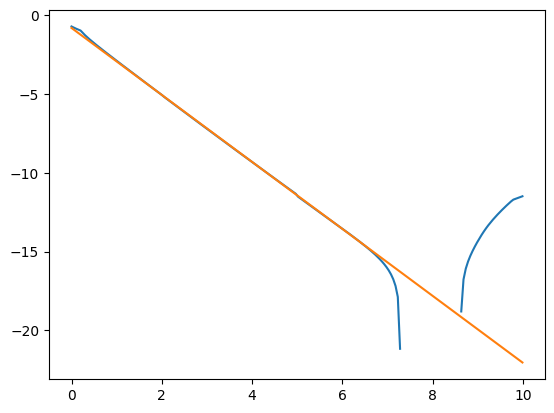

2.1253020266097344 0.4484341919995305


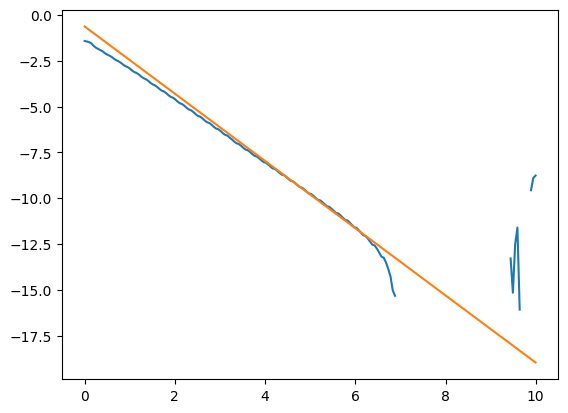

1.8319552152991005 0.5312942195957261


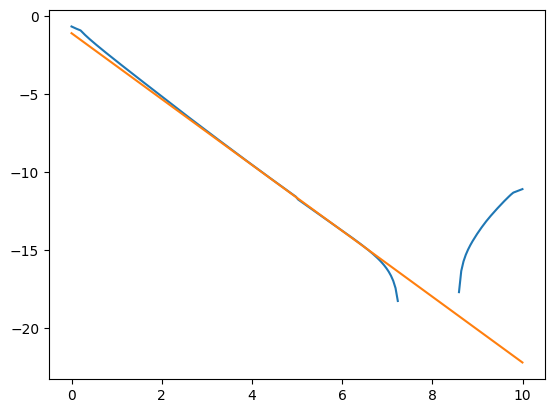

2.108667947213741 0.32988713593125335


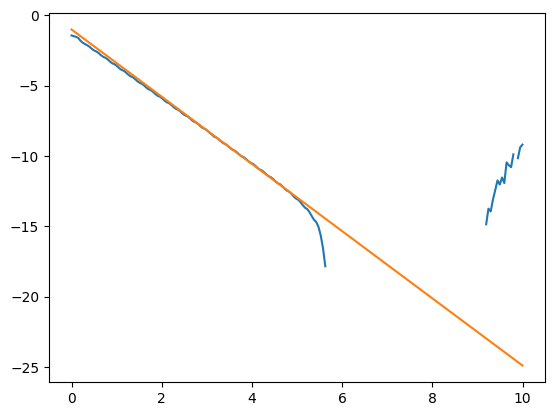

2.390209585312584 0.36473553299519


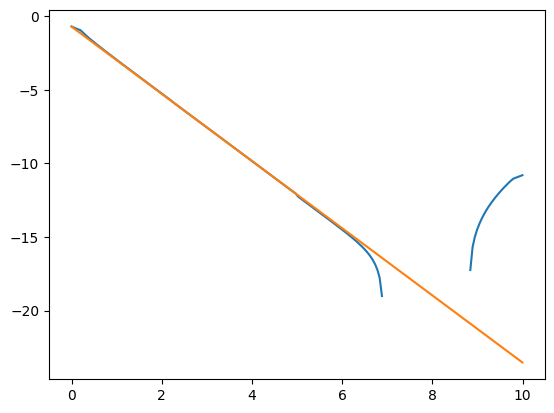

2.283859720634625 0.4960353640282855


/tmp/ipykernel_7703/2506106870.py:21: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim253015_CONF1, np.log(TsolidNondim253015_CONF1),label="Solid conf 1")
/tmp/ipykernel_7703/2506106870.py:22: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim253015_CONF2, np.log(TsolidNondim253015_CONF2),label="Solid conf 2")
/tmp/ipykernel_7703/2506106870.py:23: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim253015_CONF3, np.log(TsolidNondim253015_CONF3),label="Solid conf 3")
/tmp/ipykernel_7703/2506106870.py:24: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim253015_CONF1, np.log(TfluidNondim253015_CONF1),label="Fluid conf 1",linestyle="dashed")
/tmp/ipykernel_7703/2506106870.py:25: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim253015_CONF2, np.log(TfluidNondim253015_CONF2),label="Fluid conf 2",linestyle="dashed")
/tmp/ipykernel_7703/2506106870.py:26: RuntimeWarning: invalid value encountered in log


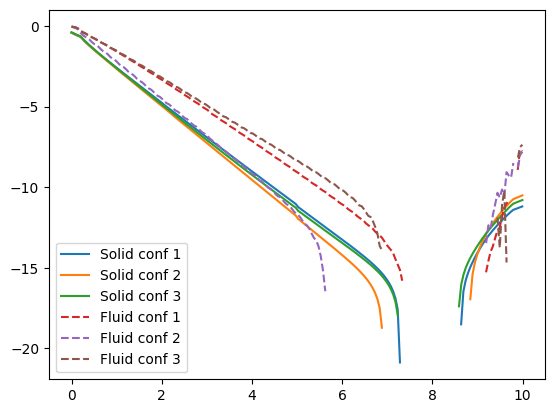

In [ ]:
# sAME FOR ALL CASES:
_, _, _, _, _, parameters = resP25Re20t15_CONF1
_, _, _, _, epsi, _, R, _, _, _, _, Rchannels = parameters 

zmin = 4.0
zmax = 6.5
z_nondim253015_CONF1, TsolidNondim253015_CONF1, TfluidNondim253015_CONF1 = nondimensionalize(resP25Re30t15_CONF1)
lamf2530_CONF1, gamf2530_CONF1 = adjust_to_exponential(z_nondim253015_CONF1, epsi*np.array(TfluidNondim253015_CONF1), zmin, zmax)
lams2530_CONF1, gams2530_CONF1 = adjust_to_exponential(z_nondim253015_CONF1, (1 - epsi)*np.array(TsolidNondim253015_CONF1), zmin, zmax)

z_nondim253015_CONF3, TsolidNondim253015_CONF3, TfluidNondim253015_CONF3 = nondimensionalize(resP25Re30t15_CONF3)
lamf2530_CONF3, gamf2530_CONF3 = adjust_to_exponential(z_nondim253015_CONF3, epsi*np.array(TfluidNondim253015_CONF3), zmin, zmax)
lams2530_CONF3, gams2530_CONF3 = adjust_to_exponential(z_nondim253015_CONF3, (1 - epsi)*np.array(TsolidNondim253015_CONF3), zmin, zmax)

zmin = 3.0
zmax = 5.0
z_nondim253015_CONF2, TsolidNondim253015_CONF2, TfluidNondim253015_CONF2 = nondimensionalize(resP25Re30t15_CONF2)
lamf2530_CONF2, gamf2530_CONF2 = adjust_to_exponential(z_nondim253015_CONF2, epsi*np.array(TfluidNondim253015_CONF2), zmin, zmax)
lams2530_CONF2, gams2530_CONF2 = adjust_to_exponential(z_nondim253015_CONF2, (1 - epsi)*np.array(TsolidNondim253015_CONF2), zmin, zmax)

plt.plot(z_nondim253015_CONF1, np.log(TsolidNondim253015_CONF1),label="Solid conf 1")
plt.plot(z_nondim253015_CONF2, np.log(TsolidNondim253015_CONF2),label="Solid conf 2")
plt.plot(z_nondim253015_CONF3, np.log(TsolidNondim253015_CONF3),label="Solid conf 3")
plt.plot(z_nondim253015_CONF1, np.log(TfluidNondim253015_CONF1),label="Fluid conf 1",linestyle="dashed")
plt.plot(z_nondim253015_CONF2, np.log(TfluidNondim253015_CONF2),label="Fluid conf 2",linestyle="dashed")
plt.plot(z_nondim253015_CONF3, np.log(TfluidNondim253015_CONF3),label="Fluid conf 3",linestyle="dashed")
plt.legend()
plt.show()

/tmp/ipykernel_7703/1253753347.py:305: RuntimeWarning: invalid value encountered in log
  yvals = np.log(TNondim)


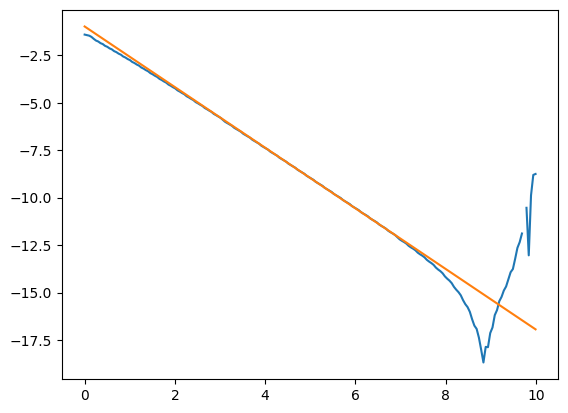

1.595770087404148 0.37251300492906925


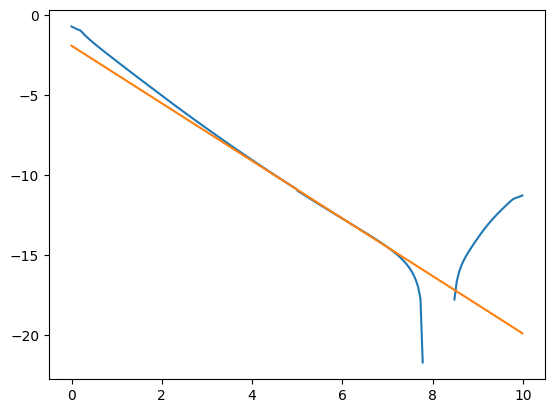

1.7965777879292688 0.14807579068743337


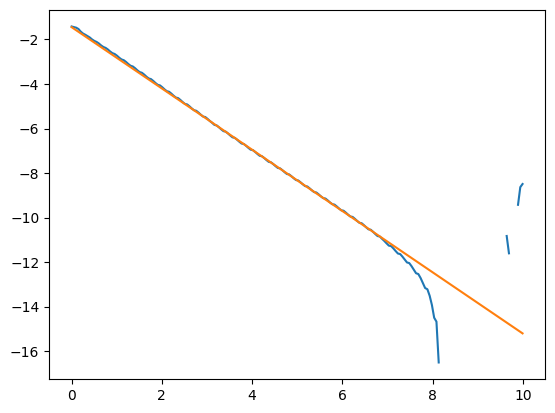

1.3760956631286707 0.23526307064581004


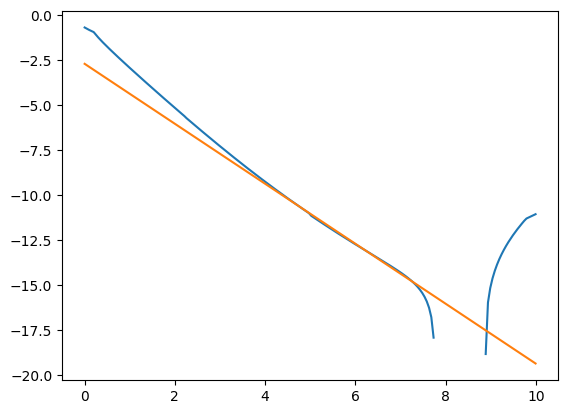

1.6641433710821718 0.06672237352739795


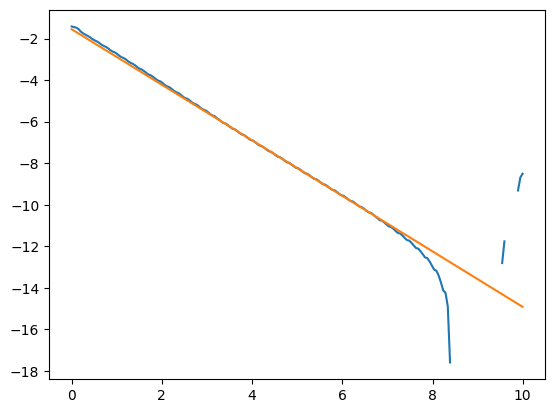

1.3366593822505486 0.21215198753201198


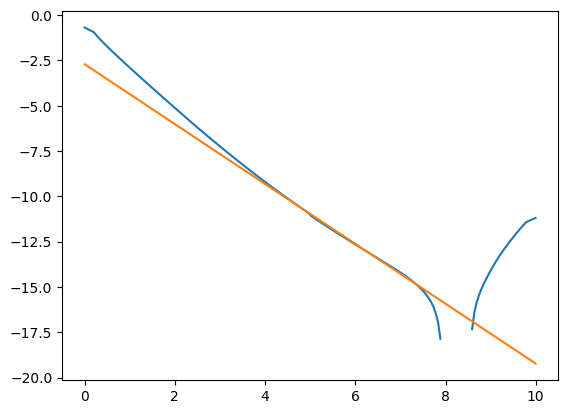

1.65241289919799 0.06675744360482992


/tmp/ipykernel_7703/2901209632.py:19: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim254015_CONF1, np.log(TsolidNondim254015_CONF1),label="Solid conf 1")
/tmp/ipykernel_7703/2901209632.py:20: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim254015_CONF2, np.log(TsolidNondim254015_CONF2),label="Solid conf 2")
/tmp/ipykernel_7703/2901209632.py:21: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim254015_CONF3, np.log(TsolidNondim254015_CONF3),label="Solid conf 3")
/tmp/ipykernel_7703/2901209632.py:22: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim254015_CONF1, np.log(TfluidNondim254015_CONF1),label="Fluid conf 1",linestyle="dashed")
/tmp/ipykernel_7703/2901209632.py:23: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim254015_CONF2, np.log(TfluidNondim254015_CONF2),label="Fluid conf 2",linestyle="dashed")
/tmp/ipykernel_7703/2901209632.py:24: RuntimeWarning: invalid value encountered in log


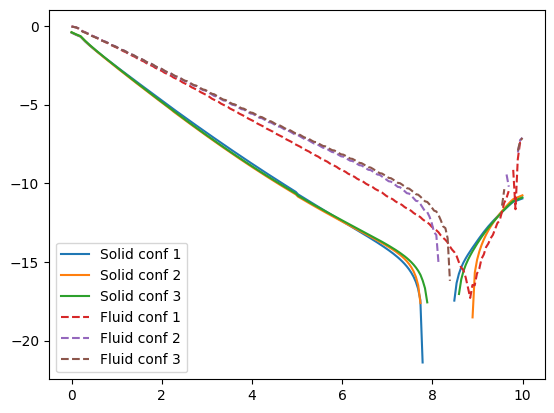

In [ ]:
# sAME FOR ALL CASES:
_, _, _, _, _, parameters = resP25Re40t15_CONF1
_, _, _, _, epsi, _, R, _, _, _, _, Rchannels = parameters 

zmin = 4.0
zmax = 7.0
z_nondim254015_CONF1, TsolidNondim254015_CONF1, TfluidNondim254015_CONF1 = nondimensionalize(resP25Re40t15_CONF1)
lamf2540_CONF1, gamf2540_CONF1 = adjust_to_exponential(z_nondim254015_CONF1, epsi*np.array(TfluidNondim254015_CONF1), zmin, zmax)
lams2540_CONF1, gams2540_CONF1 = adjust_to_exponential(z_nondim254015_CONF1, (1 - epsi)*np.array(TsolidNondim254015_CONF1), zmin, zmax)

z_nondim254015_CONF2, TsolidNondim254015_CONF2, TfluidNondim254015_CONF2 = nondimensionalize(resP25Re40t15_CONF2)
lamf2540_CONF2, gamf2540_CONF2 = adjust_to_exponential(z_nondim254015_CONF2, epsi*np.array(TfluidNondim254015_CONF2), zmin, zmax)
lams2540_CONF2, gams2540_CONF2 = adjust_to_exponential(z_nondim254015_CONF2, (1 - epsi)*np.array(TsolidNondim254015_CONF2), zmin, zmax)

z_nondim254015_CONF3, TsolidNondim254015_CONF3, TfluidNondim254015_CONF3 = nondimensionalize(resP25Re40t15_CONF3)
lamf2540_CONF3, gamf2540_CONF3 = adjust_to_exponential(z_nondim254015_CONF3, epsi*np.array(TfluidNondim254015_CONF3), zmin, zmax)
lams2540_CONF3, gams2540_CONF3 = adjust_to_exponential(z_nondim254015_CONF3, (1 - epsi)*np.array(TsolidNondim254015_CONF3), zmin, zmax)

plt.plot(z_nondim254015_CONF1, np.log(TsolidNondim254015_CONF1),label="Solid conf 1")
plt.plot(z_nondim254015_CONF2, np.log(TsolidNondim254015_CONF2),label="Solid conf 2")
plt.plot(z_nondim254015_CONF3, np.log(TsolidNondim254015_CONF3),label="Solid conf 3")
plt.plot(z_nondim254015_CONF1, np.log(TfluidNondim254015_CONF1),label="Fluid conf 1",linestyle="dashed")
plt.plot(z_nondim254015_CONF2, np.log(TfluidNondim254015_CONF2),label="Fluid conf 2",linestyle="dashed")
plt.plot(z_nondim254015_CONF3, np.log(TfluidNondim254015_CONF3),label="Fluid conf 3",linestyle="dashed")
plt.legend()
plt.show()

/tmp/ipykernel_7703/1253753347.py:305: RuntimeWarning: invalid value encountered in log
  yvals = np.log(TNondim)


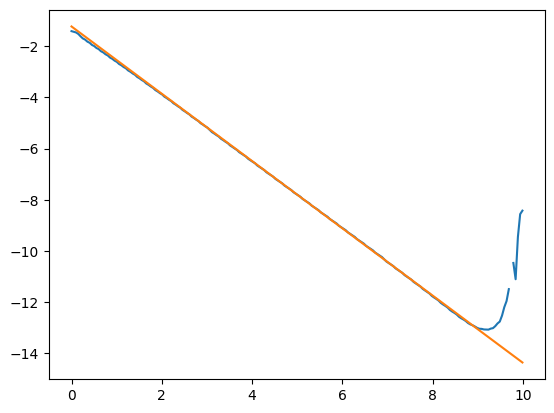

1.3133365601627789 0.2924072479745845


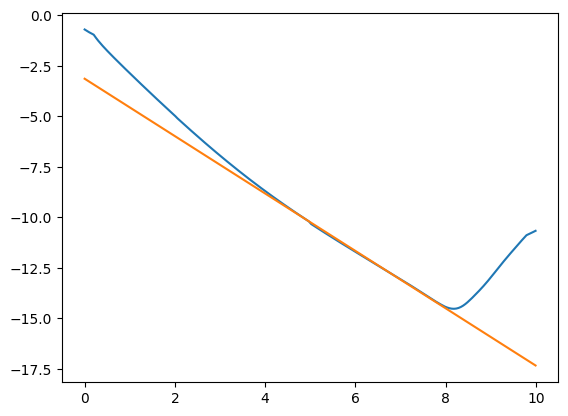

1.4197478491961089 0.043081090007721326


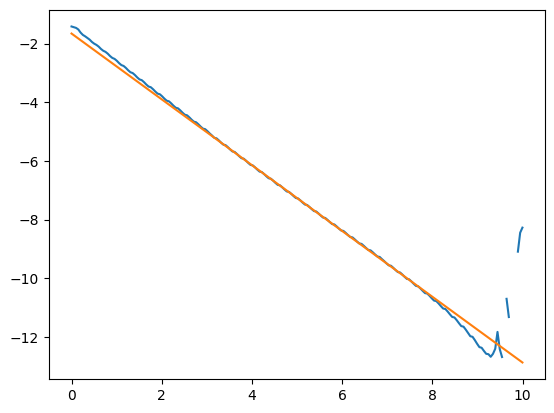

1.1225718723509452 0.19118883217168273


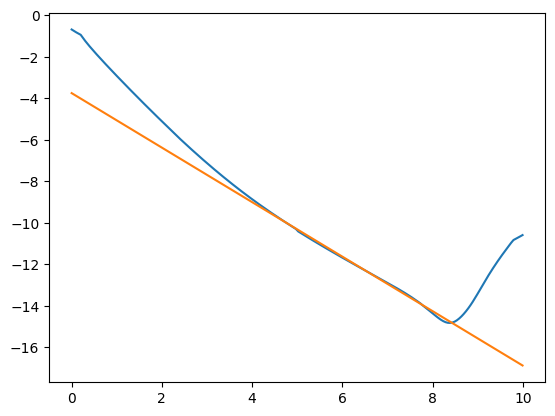

1.31254772492762 0.02339053345100779


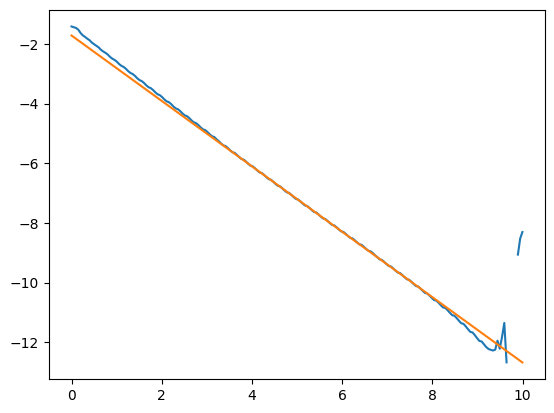

1.096189810219519 0.1795357663481081


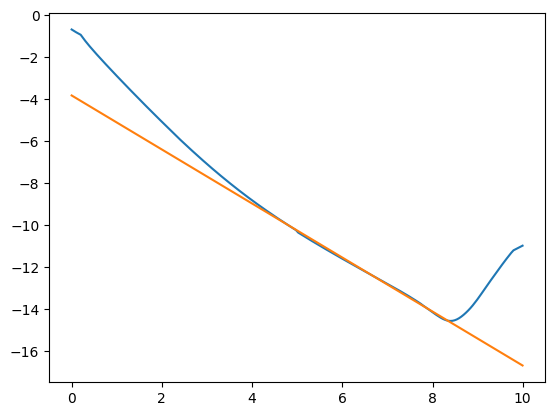

1.287716052897634 0.021841646836454103


/tmp/ipykernel_7703/2291059239.py:22: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim255015_CONF1, np.log(TfluidNondim255015_CONF1),label="Fluid conf 1",linestyle="dashed")
/tmp/ipykernel_7703/2291059239.py:23: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim255015_CONF2, np.log(TfluidNondim255015_CONF2),label="Fluid conf 2",linestyle="dashed")
/tmp/ipykernel_7703/2291059239.py:24: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim255015_CONF3, np.log(TfluidNondim255015_CONF3),label="Fluid conf 3",linestyle="dashed")


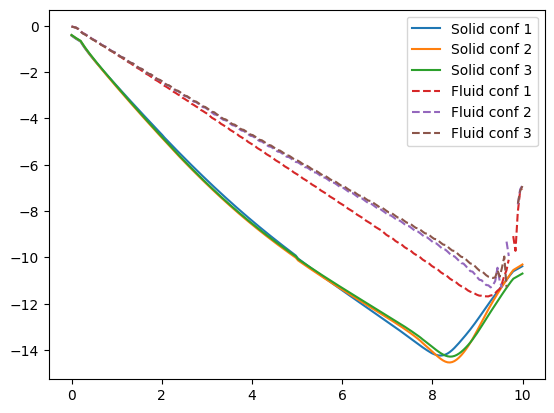

In [ ]:
# sAME FOR ALL CASES:
_, _, _, _, _, parameters = resP25Re40t15_CONF1
_, _, _, _, epsi, _, R, _, _, _, _, Rchannels = parameters 

zmin = 4.0
zmax = 8.0
z_nondim255015_CONF1, TsolidNondim255015_CONF1, TfluidNondim255015_CONF1 = nondimensionalize(resP25Re50t15_CONF1)
lamf2550_CONF1, gamf2550_CONF1 = adjust_to_exponential(z_nondim255015_CONF1, epsi*np.array(TfluidNondim255015_CONF1), zmin, zmax)
lams2550_CONF1, gams2550_CONF1 = adjust_to_exponential(z_nondim255015_CONF1, (1 - epsi)*np.array(TsolidNondim255015_CONF1), zmin, zmax)

z_nondim255015_CONF2, TsolidNondim255015_CONF2, TfluidNondim255015_CONF2 = nondimensionalize(resP25Re50t15_CONF2)
lamf2550_CONF2, gamf2550_CONF2 = adjust_to_exponential(z_nondim255015_CONF2, epsi*np.array(TfluidNondim255015_CONF2), zmin, zmax)
lams2550_CONF2, gams2550_CONF2 = adjust_to_exponential(z_nondim255015_CONF2, (1 - epsi)*np.array(TsolidNondim255015_CONF2), zmin, zmax)

z_nondim255015_CONF3, TsolidNondim255015_CONF3, TfluidNondim255015_CONF3 = nondimensionalize(resP25Re50t15_CONF3)
lamf2550_CONF3, gamf2550_CONF3 = adjust_to_exponential(z_nondim255015_CONF3, epsi*np.array(TfluidNondim255015_CONF3), zmin, zmax)
lams2550_CONF3, gams2550_CONF3 = adjust_to_exponential(z_nondim255015_CONF3, (1 - epsi)*np.array(TsolidNondim255015_CONF3), zmin, zmax)

plt.plot(z_nondim255015_CONF1, np.log(TsolidNondim255015_CONF1),label="Solid conf 1")
plt.plot(z_nondim255015_CONF2, np.log(TsolidNondim255015_CONF2),label="Solid conf 2")
plt.plot(z_nondim255015_CONF3, np.log(TsolidNondim255015_CONF3),label="Solid conf 3")
plt.plot(z_nondim255015_CONF1, np.log(TfluidNondim255015_CONF1),label="Fluid conf 1",linestyle="dashed")
plt.plot(z_nondim255015_CONF2, np.log(TfluidNondim255015_CONF2),label="Fluid conf 2",linestyle="dashed")
plt.plot(z_nondim255015_CONF3, np.log(TfluidNondim255015_CONF3),label="Fluid conf 3",linestyle="dashed")
plt.legend()
plt.show()

/tmp/ipykernel_10031/642430968.py:305: RuntimeWarning: invalid value encountered in log
  yvals = np.log(TNondim)
/tmp/ipykernel_10031/871987217.py:22: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim256015_CONF1, np.log(TfluidNondim256015_CONF1),label="Fluid conf 1",linestyle="dashed")
/tmp/ipykernel_10031/871987217.py:23: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim256015_CONF2, np.log(TfluidNondim256015_CONF2),label="Fluid conf 2",linestyle="dashed")
/tmp/ipykernel_10031/871987217.py:24: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim256015_CONF3, np.log(TfluidNondim256015_CONF3),label="Fluid conf 3",linestyle="dashed")


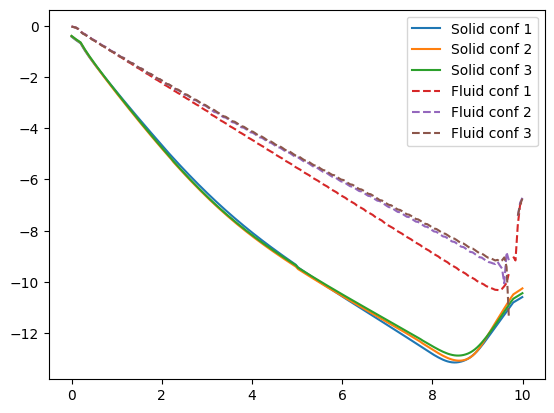

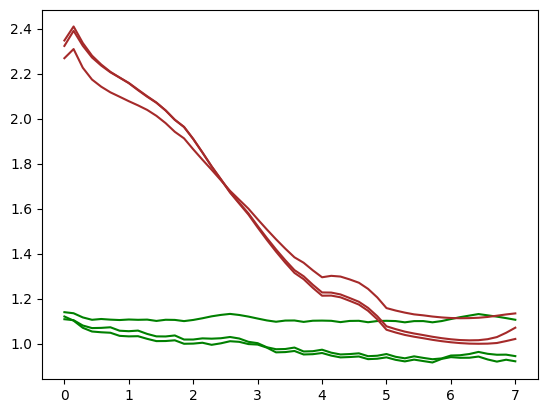

In [ ]:
# sAME FOR ALL CASES:
_, _, _, _, _, parameters = resP25Re60t15_CONF1
_, _, _, _, epsi, _, R, _, _, _, _, Rchannels = parameters 

zmin = 0.0
zmax = 8.0
z_nondim256015_CONF1, TsolidNondim256015_CONF1, TfluidNondim256015_CONF1 = nondimensionalize(resP25Re60t15_CONF1)
lamf2560_CONF1, gamf2560_CONF1 = adjust_to_exponential(z_nondim256015_CONF1, epsi*np.array(TfluidNondim256015_CONF1), zmin, zmax)
lams2560_CONF1, gams2560_CONF1 = adjust_to_exponential(z_nondim256015_CONF1, (1 - epsi)*np.array(TsolidNondim256015_CONF1), zmin, zmax)

z_nondim256015_CONF2, TsolidNondim256015_CONF2, TfluidNondim256015_CONF2 = nondimensionalize(resP25Re60t15_CONF2)
lamf2560_CONF2, gamf2560_CONF2 = adjust_to_exponential(z_nondim256015_CONF2, epsi*np.array(TfluidNondim256015_CONF2), zmin, zmax)
lams2560_CONF2, gams2560_CONF2 = adjust_to_exponential(z_nondim256015_CONF2, (1 - epsi)*np.array(TsolidNondim256015_CONF2), zmin, zmax)

z_nondim256015_CONF3, TsolidNondim256015_CONF3, TfluidNondim256015_CONF3 = nondimensionalize(resP25Re60t15_CONF3)
lamf2560_CONF3, gamf2560_CONF3 = adjust_to_exponential(z_nondim256015_CONF3, epsi*np.array(TfluidNondim256015_CONF3), zmin, zmax)
lams2560_CONF3, gams2560_CONF3 = adjust_to_exponential(z_nondim256015_CONF3, (1 - epsi)*np.array(TsolidNondim256015_CONF3), zmin, zmax)

plt.plot(z_nondim256015_CONF1, np.log(TsolidNondim256015_CONF1),label="Solid conf 1")
plt.plot(z_nondim256015_CONF2, np.log(TsolidNondim256015_CONF2),label="Solid conf 2")
plt.plot(z_nondim256015_CONF3, np.log(TsolidNondim256015_CONF3),label="Solid conf 3")
plt.plot(z_nondim256015_CONF1, np.log(TfluidNondim256015_CONF1),label="Fluid conf 1",linestyle="dashed")
plt.plot(z_nondim256015_CONF2, np.log(TfluidNondim256015_CONF2),label="Fluid conf 2",linestyle="dashed")
plt.plot(z_nondim256015_CONF3, np.log(TfluidNondim256015_CONF3),label="Fluid conf 3",linestyle="dashed")
plt.legend()
plt.show()

# Evolution of lamda:
zr_width = 1.0
zrange = np.linspace(zmin,zmax-zr_width,50)
lamfCONF1 = []
lamsCONF1 = []
lamfCONF2 = []
lamsCONF2 = []
lamfCONF3 = []
lamsCONF3 = []
for z in zrange:
    lf1, _ = adjust_to_exponential(z_nondim256015_CONF1, epsi*np.array(TfluidNondim256015_CONF1), z, z+zr_width)
    lamfCONF1.append(lf1)
    ls1, _ = adjust_to_exponential(z_nondim256015_CONF1, (1 - epsi)*np.array(TsolidNondim256015_CONF1), z, z+zr_width)
    lamsCONF1.append(ls1)
    lf2, _ = adjust_to_exponential(z_nondim256015_CONF2, epsi*np.array(TfluidNondim256015_CONF2), z, z+zr_width)
    lamfCONF2.append(lf2)
    ls2, _ = adjust_to_exponential(z_nondim256015_CONF2, (1 - epsi)*np.array(TsolidNondim256015_CONF2), z, z+zr_width)
    lamsCONF2.append(ls2)
    lf3, _ = adjust_to_exponential(z_nondim256015_CONF3, epsi*np.array(TfluidNondim256015_CONF3), z, z+zr_width)
    lamfCONF3.append(lf3)
    ls3, _ = adjust_to_exponential(z_nondim256015_CONF3, (1 - epsi)*np.array(TsolidNondim256015_CONF3), z, z+zr_width)
    lamsCONF3.append(ls3)

plt.plot(zrange, lamfCONF1, color="green")
plt.plot(zrange, lamsCONF1, color="brown")
plt.plot(zrange, lamfCONF2, color="green")
plt.plot(zrange, lamsCONF2, color="brown")
plt.plot(zrange, lamfCONF3, color="green")
plt.plot(zrange, lamsCONF3, color="brown")
plt.show()



/tmp/ipykernel_15931/642430968.py:305: RuntimeWarning: invalid value encountered in log
  yvals = np.log(TNondim)
/tmp/ipykernel_15931/2053198031.py:22: RuntimeWarning: invalid value encountered in log
  plt.plot(z_nondim257015_CONF1, np.log(TfluidNondim257015_CONF1),label="Fluid conf 1",linestyle="dashed")


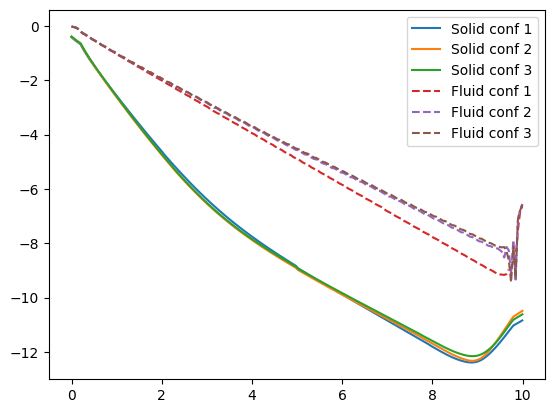

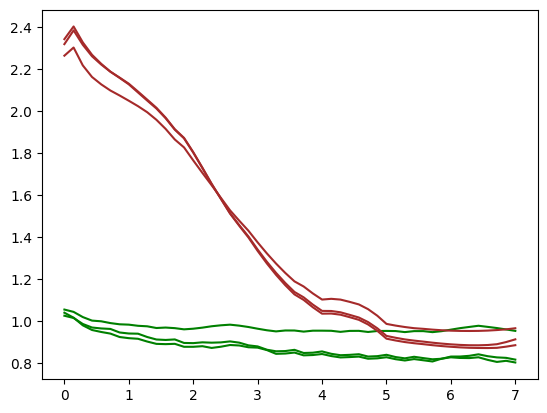

In [ ]:
# sAME FOR ALL CASES:
_, _, _, _, _, parameters = resP25Re70t15_CONF1
_, _, _, _, epsi, _, R, _, _, _, _, Rchannels = parameters 

zmin = 5.0
zmax = 8.0
z_nondim257015_CONF1, TsolidNondim257015_CONF1, TfluidNondim257015_CONF1 = nondimensionalize(resP25Re70t15_CONF1)
lamf2570_CONF1, gamf2570_CONF1 = adjust_to_exponential(z_nondim257015_CONF1, epsi*np.array(TfluidNondim257015_CONF1), zmin, zmax)
lams2570_CONF1, gams2570_CONF1 = adjust_to_exponential(z_nondim257015_CONF1, (1 - epsi)*np.array(TsolidNondim257015_CONF1), zmin, zmax)

z_nondim257015_CONF2, TsolidNondim257015_CONF2, TfluidNondim257015_CONF2 = nondimensionalize(resP25Re70t15_CONF2)
lamf2570_CONF2, gamf2570_CONF2 = adjust_to_exponential(z_nondim257015_CONF2, epsi*np.array(TfluidNondim257015_CONF2), zmin, zmax)
lams2570_CONF2, gams2570_CONF2 = adjust_to_exponential(z_nondim257015_CONF2, (1 - epsi)*np.array(TsolidNondim257015_CONF2), zmin, zmax)

z_nondim257015_CONF3, TsolidNondim257015_CONF3, TfluidNondim257015_CONF3 = nondimensionalize(resP25Re70t15_CONF3)
lamf2570_CONF3, gamf2570_CONF3 = adjust_to_exponential(z_nondim257015_CONF3, epsi*np.array(TfluidNondim257015_CONF3), zmin, zmax)
lams2570_CONF3, gams2570_CONF3 = adjust_to_exponential(z_nondim257015_CONF3, (1 - epsi)*np.array(TsolidNondim257015_CONF3), zmin, zmax)

plt.plot(z_nondim257015_CONF1, np.log(TsolidNondim257015_CONF1),label="Solid conf 1")
plt.plot(z_nondim257015_CONF2, np.log(TsolidNondim257015_CONF2),label="Solid conf 2")
plt.plot(z_nondim257015_CONF3, np.log(TsolidNondim257015_CONF3),label="Solid conf 3")
plt.plot(z_nondim257015_CONF1, np.log(TfluidNondim257015_CONF1),label="Fluid conf 1",linestyle="dashed")
plt.plot(z_nondim257015_CONF2, np.log(TfluidNondim257015_CONF2),label="Fluid conf 2",linestyle="dashed")
plt.plot(z_nondim257015_CONF3, np.log(TfluidNondim257015_CONF3),label="Fluid conf 3",linestyle="dashed")
plt.legend()
plt.show()

# Evolution of lamda:
zr_width = 1.0
zrange = np.linspace(0.0,zmax-zr_width,50)
lamfCONF1 = []
lamsCONF1 = []
lamfCONF2 = []
lamsCONF2 = []
lamfCONF3 = []
lamsCONF3 = []
for z in zrange:
    lf1, _ = adjust_to_exponential(z_nondim257015_CONF1, epsi*np.array(TfluidNondim257015_CONF1), z, z+zr_width)
    lamfCONF1.append(lf1)
    ls1, _ = adjust_to_exponential(z_nondim257015_CONF1, (1 - epsi)*np.array(TsolidNondim257015_CONF1), z, z+zr_width)
    lamsCONF1.append(ls1)
    lf2, _ = adjust_to_exponential(z_nondim257015_CONF2, epsi*np.array(TfluidNondim257015_CONF2), z, z+zr_width)
    lamfCONF2.append(lf2)
    ls2, _ = adjust_to_exponential(z_nondim257015_CONF2, (1 - epsi)*np.array(TsolidNondim257015_CONF2), z, z+zr_width)
    lamsCONF2.append(ls2)
    lf3, _ = adjust_to_exponential(z_nondim257015_CONF3, epsi*np.array(TfluidNondim257015_CONF3), z, z+zr_width)
    lamfCONF3.append(lf3)
    ls3, _ = adjust_to_exponential(z_nondim257015_CONF3, (1 - epsi)*np.array(TsolidNondim257015_CONF3), z, z+zr_width)
    lamsCONF3.append(ls3)

plt.plot(zrange, lamfCONF1, color="green")
plt.plot(zrange, lamsCONF1, color="brown")
plt.plot(zrange, lamfCONF2, color="green")
plt.plot(zrange, lamsCONF2, color="brown")
plt.plot(zrange, lamfCONF3, color="green")
plt.plot(zrange, lamsCONF3, color="brown")
plt.show()


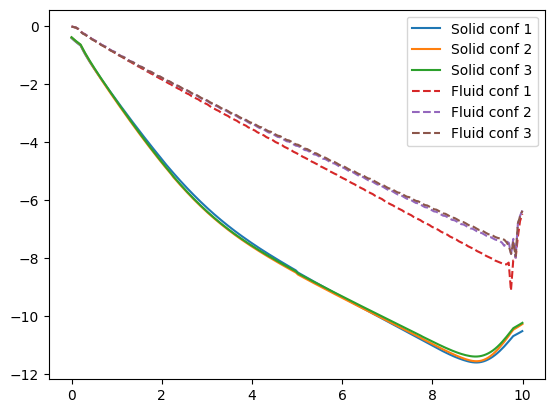

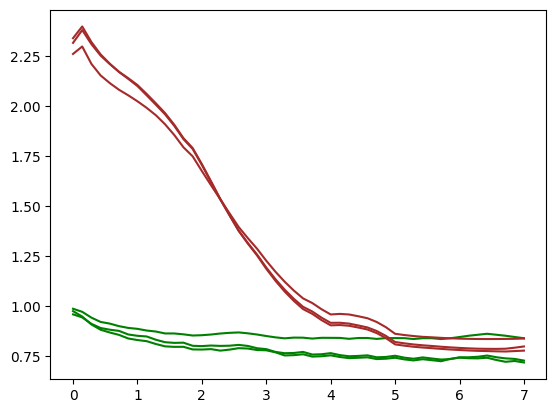

In [ ]:
# sAME FOR ALL CASES:
_, _, _, _, _, parameters = resP25Re80t15_CONF1
_, _, _, _, epsi, _, R, _, _, _, _, Rchannels = parameters 

zmin = 5.0
zmax = 8.0
z_nondim258015_CONF1, TsolidNondim258015_CONF1, TfluidNondim258015_CONF1 = nondimensionalize(resP25Re80t15_CONF1)
lamf2580_CONF1, gamf2580_CONF1 = adjust_to_exponential(z_nondim258015_CONF1, epsi*np.array(TfluidNondim258015_CONF1), zmin, zmax)
lams2580_CONF1, gams2580_CONF1 = adjust_to_exponential(z_nondim258015_CONF1, (1 - epsi)*np.array(TsolidNondim258015_CONF1), zmin, zmax)

z_nondim258015_CONF2, TsolidNondim258015_CONF2, TfluidNondim258015_CONF2 = nondimensionalize(resP25Re80t15_CONF2)
lamf2580_CONF2, gamf2580_CONF2 = adjust_to_exponential(z_nondim258015_CONF2, epsi*np.array(TfluidNondim258015_CONF2), zmin, zmax)
lams2580_CONF2, gams2580_CONF2 = adjust_to_exponential(z_nondim258015_CONF2, (1 - epsi)*np.array(TsolidNondim258015_CONF2), zmin, zmax)

z_nondim258015_CONF3, TsolidNondim258015_CONF3, TfluidNondim258015_CONF3 = nondimensionalize(resP25Re80t15_CONF3)
lamf2580_CONF3, gamf2580_CONF3 = adjust_to_exponential(z_nondim258015_CONF3, epsi*np.array(TfluidNondim258015_CONF3), zmin, zmax)
lams2580_CONF3, gams2580_CONF3 = adjust_to_exponential(z_nondim258015_CONF3, (1 - epsi)*np.array(TsolidNondim258015_CONF3), zmin, zmax)

plt.plot(z_nondim258015_CONF1, np.log(TsolidNondim258015_CONF1),label="Solid conf 1")
plt.plot(z_nondim258015_CONF2, np.log(TsolidNondim258015_CONF2),label="Solid conf 2")
plt.plot(z_nondim258015_CONF3, np.log(TsolidNondim258015_CONF3),label="Solid conf 3")
plt.plot(z_nondim258015_CONF1, np.log(TfluidNondim258015_CONF1),label="Fluid conf 1",linestyle="dashed")
plt.plot(z_nondim258015_CONF2, np.log(TfluidNondim258015_CONF2),label="Fluid conf 2",linestyle="dashed")
plt.plot(z_nondim258015_CONF3, np.log(TfluidNondim258015_CONF3),label="Fluid conf 3",linestyle="dashed")
plt.legend()
plt.show()

# Evolution of lamda:
zr_width = 1.0
zrange = np.linspace(0.0,zmax-zr_width,50)
lamfCONF1 = []
lamsCONF1 = []
lamfCONF2 = []
lamsCONF2 = []
lamfCONF3 = []
lamsCONF3 = []
for z in zrange:
    lf1, _ = adjust_to_exponential(z_nondim258015_CONF1, epsi*np.array(TfluidNondim258015_CONF1), z, z+zr_width)
    lamfCONF1.append(lf1)
    ls1, _ = adjust_to_exponential(z_nondim258015_CONF1, (1 - epsi)*np.array(TsolidNondim258015_CONF1), z, z+zr_width)
    lamsCONF1.append(ls1)
    lf2, _ = adjust_to_exponential(z_nondim258015_CONF2, epsi*np.array(TfluidNondim258015_CONF2), z, z+zr_width)
    lamfCONF2.append(lf2)
    ls2, _ = adjust_to_exponential(z_nondim258015_CONF2, (1 - epsi)*np.array(TsolidNondim258015_CONF2), z, z+zr_width)
    lamsCONF2.append(ls2)
    lf3, _ = adjust_to_exponential(z_nondim258015_CONF3, epsi*np.array(TfluidNondim258015_CONF3), z, z+zr_width)
    lamfCONF3.append(lf3)
    ls3, _ = adjust_to_exponential(z_nondim258015_CONF3, (1 - epsi)*np.array(TsolidNondim258015_CONF3), z, z+zr_width)
    lamsCONF3.append(ls3)

plt.plot(zrange, lamfCONF1, color="green")
plt.plot(zrange, lamsCONF1, color="brown")
plt.plot(zrange, lamfCONF2, color="green")
plt.plot(zrange, lamsCONF2, color="brown")
plt.plot(zrange, lamfCONF3, color="green")
plt.plot(zrange, lamsCONF3, color="brown")
plt.show()


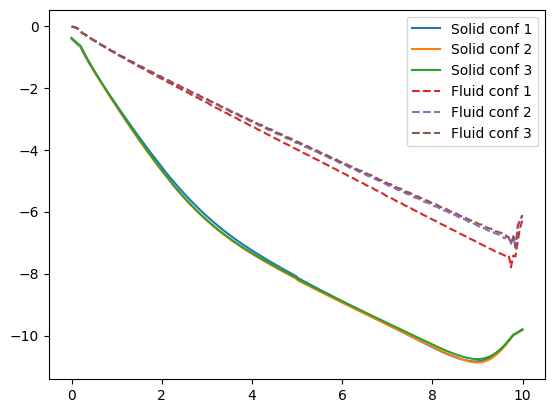

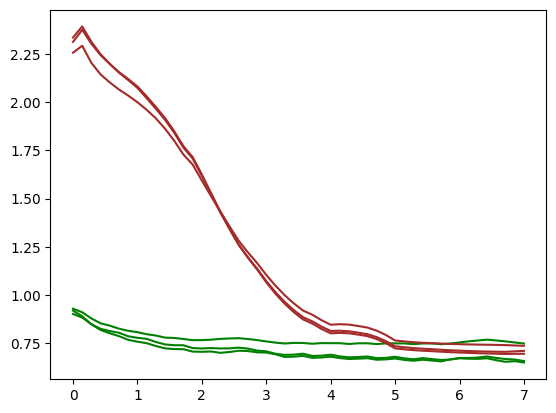

In [ ]:
# sAME FOR ALL CASES:
_, _, _, _, _, parameters = resP25Re90t15_CONF1
_, _, _, _, epsi, _, R, _, _, _, _, Rchannels = parameters 

zmin = 5.0
zmax = 8.0
z_nondim259015_CONF1, TsolidNondim259015_CONF1, TfluidNondim259015_CONF1 = nondimensionalize(resP25Re90t15_CONF1)
lamf2590_CONF1, gamf2590_CONF1 = adjust_to_exponential(z_nondim259015_CONF1, epsi*np.array(TfluidNondim259015_CONF1), zmin, zmax)
lams2590_CONF1, gams2590_CONF1 = adjust_to_exponential(z_nondim259015_CONF1, (1 - epsi)*np.array(TsolidNondim259015_CONF1), zmin, zmax)

z_nondim259015_CONF2, TsolidNondim259015_CONF2, TfluidNondim259015_CONF2 = nondimensionalize(resP25Re90t15_CONF2)
lamf2590_CONF2, gamf2590_CONF2 = adjust_to_exponential(z_nondim259015_CONF2, epsi*np.array(TfluidNondim259015_CONF2), zmin, zmax)
lams2590_CONF2, gams2590_CONF2 = adjust_to_exponential(z_nondim259015_CONF2, (1 - epsi)*np.array(TsolidNondim259015_CONF2), zmin, zmax)

z_nondim259015_CONF3, TsolidNondim259015_CONF3, TfluidNondim259015_CONF3 = nondimensionalize(resP25Re90t15_CONF3)
lamf2590_CONF3, gamf2590_CONF3 = adjust_to_exponential(z_nondim259015_CONF3, epsi*np.array(TfluidNondim259015_CONF3), zmin, zmax)
lams2590_CONF3, gams2590_CONF3 = adjust_to_exponential(z_nondim259015_CONF3, (1 - epsi)*np.array(TsolidNondim259015_CONF3), zmin, zmax)

plt.plot(z_nondim259015_CONF1, np.log(TsolidNondim259015_CONF1),label="Solid conf 1")
plt.plot(z_nondim259015_CONF2, np.log(TsolidNondim259015_CONF2),label="Solid conf 2")
plt.plot(z_nondim259015_CONF3, np.log(TsolidNondim259015_CONF3),label="Solid conf 3")
plt.plot(z_nondim259015_CONF1, np.log(TfluidNondim259015_CONF1),label="Fluid conf 1",linestyle="dashed")
plt.plot(z_nondim259015_CONF2, np.log(TfluidNondim259015_CONF2),label="Fluid conf 2",linestyle="dashed")
plt.plot(z_nondim259015_CONF3, np.log(TfluidNondim259015_CONF3),label="Fluid conf 3",linestyle="dashed")
plt.legend()
plt.show()

# Evolution of lamda:
zr_width = 1.0
zrange = np.linspace(0.0,zmax-zr_width,50)
lamfCONF1 = []
lamsCONF1 = []
lamfCONF2 = []
lamsCONF2 = []
lamfCONF3 = []
lamsCONF3 = []
for z in zrange:
    lf1, _ = adjust_to_exponential(z_nondim259015_CONF1, epsi*np.array(TfluidNondim259015_CONF1), z, z+zr_width)
    lamfCONF1.append(lf1)
    ls1, _ = adjust_to_exponential(z_nondim259015_CONF1, (1 - epsi)*np.array(TsolidNondim259015_CONF1), z, z+zr_width)
    lamsCONF1.append(ls1)
    lf2, _ = adjust_to_exponential(z_nondim259015_CONF2, epsi*np.array(TfluidNondim259015_CONF2), z, z+zr_width)
    lamfCONF2.append(lf2)
    ls2, _ = adjust_to_exponential(z_nondim259015_CONF2, (1 - epsi)*np.array(TsolidNondim259015_CONF2), z, z+zr_width)
    lamsCONF2.append(ls2)
    lf3, _ = adjust_to_exponential(z_nondim259015_CONF3, epsi*np.array(TfluidNondim259015_CONF3), z, z+zr_width)
    lamfCONF3.append(lf3)
    ls3, _ = adjust_to_exponential(z_nondim259015_CONF3, (1 - epsi)*np.array(TsolidNondim259015_CONF3), z, z+zr_width)
    lamsCONF3.append(ls3)

plt.plot(zrange, lamfCONF1, color="green")
plt.plot(zrange, lamsCONF1, color="brown")
plt.plot(zrange, lamfCONF2, color="green")
plt.plot(zrange, lamsCONF2, color="brown")
plt.plot(zrange, lamfCONF3, color="green")
plt.plot(zrange, lamsCONF3, color="brown")
plt.show()

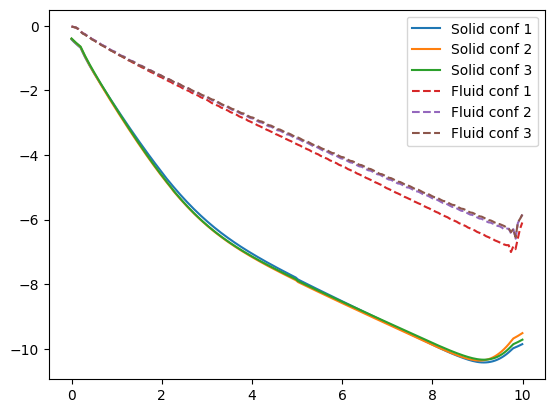

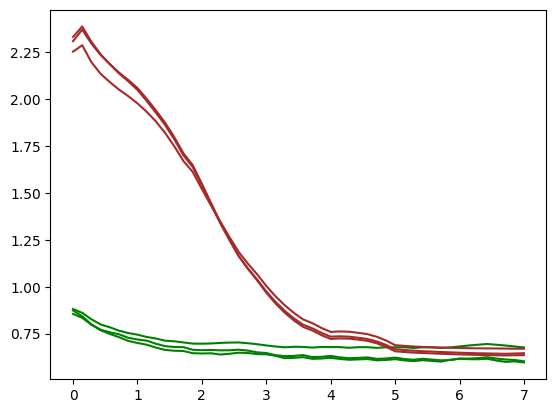

In [ ]:
# sAME FOR ALL CASES:
_, _, _, _, _, parameters = resP25Re100t15_CONF1
_, _, _, _, epsi, _, R, _, _, _, _, Rchannels = parameters 

zmin = 5.0
zmax = 8.0
z_nondim2510015_CONF1, TsolidNondim2510015_CONF1, TfluidNondim2510015_CONF1 = nondimensionalize(resP25Re100t15_CONF1)
lamf25100_CONF1, gamf25100_CONF1 = adjust_to_exponential(z_nondim2510015_CONF1, epsi*np.array(TfluidNondim2510015_CONF1), zmin, zmax)
lams25100_CONF1, gams25100_CONF1 = adjust_to_exponential(z_nondim2510015_CONF1, (1 - epsi)*np.array(TsolidNondim2510015_CONF1), zmin, zmax)

z_nondim2510015_CONF2, TsolidNondim2510015_CONF2, TfluidNondim2510015_CONF2 = nondimensionalize(resP25Re100t15_CONF2)
lamf25100_CONF2, gamf25100_CONF2 = adjust_to_exponential(z_nondim2510015_CONF2, epsi*np.array(TfluidNondim2510015_CONF2), zmin, zmax)
lams25100_CONF2, gams25100_CONF2 = adjust_to_exponential(z_nondim2510015_CONF2, (1 - epsi)*np.array(TsolidNondim2510015_CONF2), zmin, zmax)

z_nondim2510015_CONF3, TsolidNondim2510015_CONF3, TfluidNondim2510015_CONF3 = nondimensionalize(resP25Re100t15_CONF3)
lamf25100_CONF3, gamf25100_CONF3 = adjust_to_exponential(z_nondim2510015_CONF3, epsi*np.array(TfluidNondim2510015_CONF3), zmin, zmax)
lams25100_CONF3, gams25100_CONF3 = adjust_to_exponential(z_nondim2510015_CONF3, (1 - epsi)*np.array(TsolidNondim2510015_CONF3), zmin, zmax)

plt.plot(z_nondim2510015_CONF1, np.log(TsolidNondim2510015_CONF1),label="Solid conf 1")
plt.plot(z_nondim2510015_CONF2, np.log(TsolidNondim2510015_CONF2),label="Solid conf 2")
plt.plot(z_nondim2510015_CONF3, np.log(TsolidNondim2510015_CONF3),label="Solid conf 3")
plt.plot(z_nondim2510015_CONF1, np.log(TfluidNondim2510015_CONF1),label="Fluid conf 1",linestyle="dashed")
plt.plot(z_nondim2510015_CONF2, np.log(TfluidNondim2510015_CONF2),label="Fluid conf 2",linestyle="dashed")
plt.plot(z_nondim2510015_CONF3, np.log(TfluidNondim2510015_CONF3),label="Fluid conf 3",linestyle="dashed")
plt.legend()
plt.show()

# Evolution of lamda:
zr_width = 1.0
zrange = np.linspace(0.0,zmax-zr_width,50)
lamfCONF1 = []
lamsCONF1 = []
lamfCONF2 = []
lamsCONF2 = []
lamfCONF3 = []
lamsCONF3 = []
for z in zrange:
    lf1, _ = adjust_to_exponential(z_nondim2510015_CONF1, epsi*np.array(TfluidNondim2510015_CONF1), z, z+zr_width)
    lamfCONF1.append(lf1)
    ls1, _ = adjust_to_exponential(z_nondim2510015_CONF1, (1 - epsi)*np.array(TsolidNondim2510015_CONF1), z, z+zr_width)
    lamsCONF1.append(ls1)
    lf2, _ = adjust_to_exponential(z_nondim2510015_CONF2, epsi*np.array(TfluidNondim2510015_CONF2), z, z+zr_width)
    lamfCONF2.append(lf2)
    ls2, _ = adjust_to_exponential(z_nondim2510015_CONF2, (1 - epsi)*np.array(TsolidNondim2510015_CONF2), z, z+zr_width)
    lamsCONF2.append(ls2)
    lf3, _ = adjust_to_exponential(z_nondim2510015_CONF3, epsi*np.array(TfluidNondim2510015_CONF3), z, z+zr_width)
    lamfCONF3.append(lf3)
    ls3, _ = adjust_to_exponential(z_nondim2510015_CONF3, (1 - epsi)*np.array(TsolidNondim2510015_CONF3), z, z+zr_width)
    lamsCONF3.append(ls3)

plt.plot(zrange, lamfCONF1, color="green")
plt.plot(zrange, lamsCONF1, color="brown")
plt.plot(zrange, lamfCONF2, color="green")
plt.plot(zrange, lamsCONF2, color="brown")
plt.plot(zrange, lamfCONF3, color="green")
plt.plot(zrange, lamsCONF3, color="brown")
plt.show()

### Results:

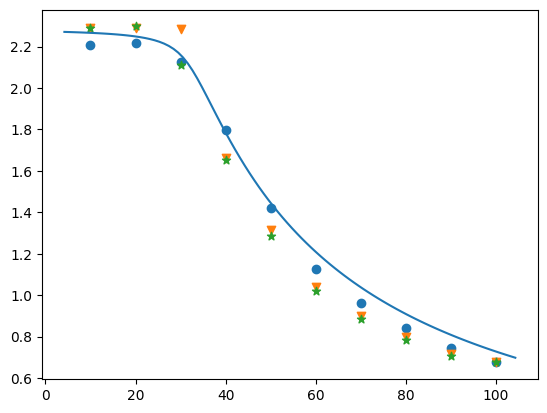

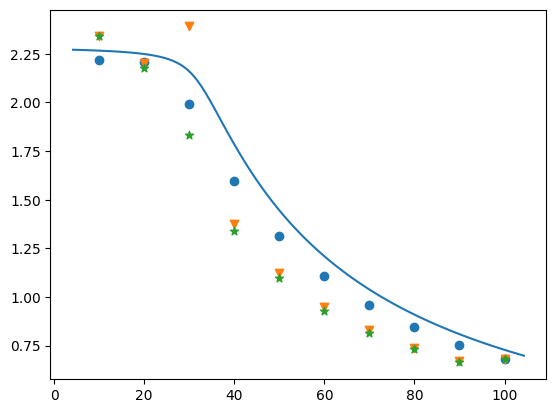

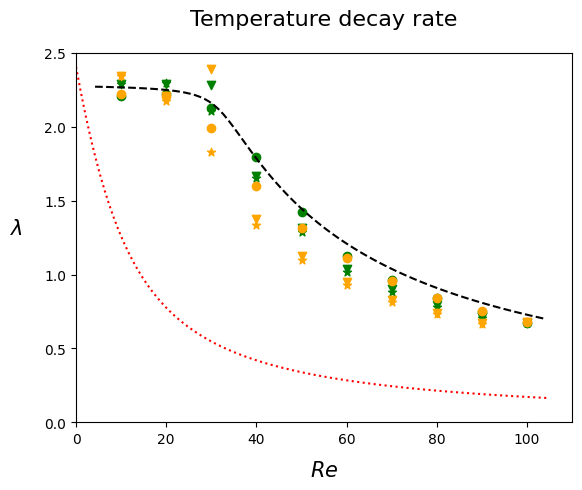

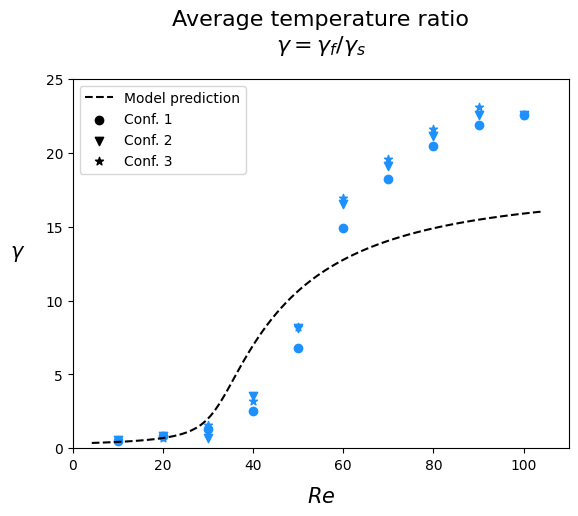

In [ ]:
"""
caseP25Re10t15_CONF1 = [lams2510_CONF1, lamf2510_CONF1, gams2510_CONF1, gamf2510_CONF1,10]
print("caseP25Re10t15_CONF1 = ", caseP25Re10t15_CONF1)
caseP25Re10t15_CONF2 = [lams2510_CONF2, lamf2510_CONF2, gams2510_CONF2, gamf2510_CONF2, 10]
print("caseP25Re10t15_CONF2 = ", caseP25Re10t15_CONF2)
caseP25Re10t15_CONF3 = [lams2510_CONF3, lamf2510_CONF3, gams2510_CONF3, gamf2510_CONF3, 10]
print("caseP25Re10t15_CONF3 = ", caseP25Re10t15_CONF3)

caseP25Re20t15_CONF1 = [lams2520_CONF1, lamf2520_CONF1, gams2520_CONF1, gamf2520_CONF1, 20]
print("caseP25Re20t15_CONF1 = ", caseP25Re20t15_CONF1)
caseP25Re20t15_CONF2 = [lams2520_CONF2, lamf2520_CONF2, gams2520_CONF2, gamf2520_CONF2, 20]
print("caseP25Re20t15_CONF2 = ", caseP25Re20t15_CONF2)
caseP25Re20t15_CONF3 = [lams2520_CONF3, lamf2520_CONF3, gams2520_CONF3, gamf2520_CONF3, 20]
print("caseP25Re20t15_CONF3 = ", caseP25Re20t15_CONF3)

caseP25Re30t15_CONF1 = [lams2530_CONF1, lamf2530_CONF1, gams2530_CONF1, gamf2530_CONF1, 30]
print("caseP25Re30t15_CONF1 = ", caseP25Re30t15_CONF1)
caseP25Re30t15_CONF2 = [lams2530_CONF2, lamf2530_CONF2, gams2530_CONF2, gamf2530_CONF2, 30]
print("caseP25Re30t15_CONF2 = ", caseP25Re30t15_CONF2)
caseP25Re30t15_CONF3 = [lams2530_CONF3, lamf2530_CONF3, gams2530_CONF3, gamf2530_CONF3, 30]
print("caseP25Re30t15_CONF3 = ", caseP25Re30t15_CONF3)

caseP25Re40t15_CONF1 = [lams2540_CONF1, lamf2540_CONF1, gams2540_CONF1, gamf2540_CONF1, 40]
print("caseP25Re40t15_CONF1 = ", caseP25Re40t15_CONF1)
caseP25Re40t15_CONF2 = [lams2540_CONF2, lamf2540_CONF2, gams2540_CONF2, gamf2540_CONF2, 40]
print("caseP25Re40t15_CONF2 = ", caseP25Re40t15_CONF2)
caseP25Re40t15_CONF3 = [lams2540_CONF3, lamf2540_CONF3, gams2540_CONF3, gamf2540_CONF3, 40]
print("caseP25Re40t15_CONF3 = ", caseP25Re40t15_CONF3)

caseP25Re50t15_CONF1 = [lams2550_CONF1, lamf2550_CONF1, gams2550_CONF1, gamf2550_CONF1, 50]
print("caseP25Re50t15_CONF1 = ", caseP25Re50t15_CONF1)
caseP25Re50t15_CONF2 = [lams2550_CONF2, lamf2550_CONF2, gams2550_CONF2, gamf2550_CONF2, 50]
print("caseP25Re50t15_CONF2 = ", caseP25Re50t15_CONF2)
caseP25Re50t15_CONF3 = [lams2550_CONF3, lamf2550_CONF3, gams2550_CONF3, gamf2550_CONF3, 50]
print("caseP25Re50t15_CONF3 = ", caseP25Re50t15_CONF3)

caseP25Re60t15_CONF1 = [lams2560_CONF1, lamf2560_CONF1, gams2560_CONF1, gamf2560_CONF1, 60]
print("caseP25Re60t15_CONF1 = ", caseP25Re60t15_CONF1)
caseP25Re60t15_CONF2 = [lams2560_CONF2, lamf2560_CONF2, gams2560_CONF2, gamf2560_CONF2, 60]
print("caseP25Re60t15_CONF2 = ", caseP25Re60t15_CONF2)
caseP25Re60t15_CONF3 = [lams2560_CONF3, lamf2560_CONF3, gams2560_CONF3, gamf2560_CONF3, 60]
print("caseP25Re60t15_CONF3 = ", caseP25Re60t15_CONF3)

caseP25Re70t15_CONF1 = [lams2570_CONF1, lamf2570_CONF1, gams2570_CONF1, gamf2570_CONF1, 70]
print("caseP25Re70t15_CONF1 = ", caseP25Re70t15_CONF1)
caseP25Re70t15_CONF2 = [lams2570_CONF2, lamf2570_CONF2, gams2570_CONF2, gamf2570_CONF2, 70]
print("caseP25Re70t15_CONF2 = ", caseP25Re70t15_CONF2)
caseP25Re70t15_CONF3 = [lams2570_CONF3, lamf2570_CONF3, gams2570_CONF3, gamf2570_CONF3, 70]
print("caseP25Re70t15_CONF3 = ", caseP25Re70t15_CONF3)

caseP25Re80t15_CONF1 = [lams2580_CONF1, lamf2580_CONF1, gams2580_CONF1, gamf2580_CONF1, 80]
print("caseP25Re80t15_CONF1 = ", caseP25Re80t15_CONF1)
caseP25Re80t15_CONF2 = [lams2580_CONF2, lamf2580_CONF2, gams2580_CONF2, gamf2580_CONF2, 80]
print("caseP25Re80t15_CONF2 = ", caseP25Re80t15_CONF2)
caseP25Re80t15_CONF3 = [lams2580_CONF3, lamf2580_CONF3, gams2580_CONF3, gamf2580_CONF3, 80]
print("caseP25Re80t15_CONF3 = ", caseP25Re80t15_CONF3)

caseP25Re90t15_CONF1 = [lams2590_CONF1, lamf2590_CONF1, gams2590_CONF1, gamf2590_CONF1, 90]
print("caseP25Re90t15_CONF1 = ", caseP25Re90t15_CONF1)
caseP25Re90t15_CONF2 = [lams2590_CONF2, lamf2590_CONF2, gams2590_CONF2, gamf2590_CONF2, 90]
print("caseP25Re90t15_CONF2 = ", caseP25Re90t15_CONF2)
caseP25Re90t15_CONF3 = [lams2590_CONF3, lamf2590_CONF3, gams2590_CONF3, gamf2590_CONF3, 90]
print("caseP25Re90t15_CONF3 = ", caseP25Re90t15_CONF3)
caseP25Re100t15_CONF1 = [lams25100_CONF1, lamf25100_CONF1, gams25100_CONF1, gamf25100_CONF1, 100]
print("caseP25Re100t15_CONF1 = ", caseP25Re100t15_CONF1)
caseP25Re100t15_CONF2 = [lams25100_CONF2, lamf25100_CONF2, gams25100_CONF2, gamf25100_CONF2, 100]
print("caseP25Re100t15_CONF2 = ", caseP25Re100t15_CONF2)
caseP25Re100t15_CONF3 = [lams25100_CONF3, lamf25100_CONF3, gams25100_CONF3, gamf25100_CONF3, 100]
print("caseP25Re100t15_CONF3 = ", caseP25Re100t15_CONF3)
"""





# Valores de los resultados (para no tener que leer las simulaciones, que lleva mucho tiempo):
caseP25Re10t15_CONF1 =  [2.2052737661206865, 2.219583746327327, 0.4938951792888308, 0.2549662801765012, 10]
caseP25Re10t15_CONF2 =  [2.2891394076797025, 2.3436122722226, 0.5065877499805629, 0.3014299568476721, 10]
caseP25Re10t15_CONF3 =  [2.2875782780854568, 2.339660882970631, 0.5261071030383818, 0.30164133175740687, 10]
caseP25Re20t15_CONF1 =  [2.218332848269583, 2.205879108203871, 0.5499547090273353, 0.44430961039869166, 20]
caseP25Re20t15_CONF2 =  [2.287668092813784, 2.204904907937684, 0.5380358583587808, 0.4332972338324992, 20]
caseP25Re20t15_CONF3 =  [2.296801927056283, 2.17452016711129, 0.581775380765136, 0.41522568995928644, 20]
caseP25Re30t15_CONF1 =  [2.1253020266097344, 1.9902367638676601, 0.4484341919995305, 0.5916369175743907, 30]
caseP25Re30t15_CONF2 =  [2.283859720634625, 2.390209585312584, 0.4960353640282855, 0.36473553299519, 30]
caseP25Re30t15_CONF3 =  [2.108667947213741, 1.8319552152991005, 0.32988713593125335, 0.5312942195957261, 30]
caseP25Re40t15_CONF1 =  [1.7965777879292688, 1.595770087404148, 0.14807579068743337, 0.37251300492906925, 40]
caseP25Re40t15_CONF2 =  [1.6641433710821718, 1.3760956631286707, 0.06672237352739795, 0.23526307064581004, 40]
caseP25Re40t15_CONF3 =  [1.65241289919799, 1.3366593822505486, 0.06675744360482992, 0.21215198753201198, 40]
caseP25Re50t15_CONF1 =  [1.4197478491961089, 1.3133365601627789, 0.043081090007721326, 0.2924072479745845, 50]
caseP25Re50t15_CONF2 =  [1.31254772492762, 1.1225718723509452, 0.02339053345100779, 0.19118883217168273, 50]
caseP25Re50t15_CONF3 =  [1.287716052897634, 1.096189810219519, 0.021841646836454103, 0.1795357663481081, 50]
caseP25Re60t15_CONF1 =  [1.1267163986938649, 1.1088432257846583, 0.016796582304019654, 0.2507014027882418, 60]
caseP25Re60t15_CONF2 =  [1.0390761517110763, 0.9464019108381165, 0.010109803469848072, 0.1671202600667275, 60]
caseP25Re60t15_CONF3 =  [1.0189527339172741, 0.9297408762254066, 0.009575538500597017, 0.16241825913539326, 60]
caseP25Re70t15_CONF1 =  [0.9619817973547538, 0.9579439721771621, 0.01235969981531407, 0.2254166195750236, 70]
caseP25Re70t15_CONF2 =  [0.8999121172202025, 0.8278705523880638, 0.0084578542262518, 0.16180237870000885, 70]
caseP25Re70t15_CONF3 =  [0.8851084786172938, 0.8165008478141635, 0.008204918314781434, 0.16055265765034502, 70]
caseP25Re80t15_CONF1 =  [0.8408036450693518, 0.8435811454256273, 0.010304305929780185, 0.2104418951152728, 80]
caseP25Re80t15_CONF2 =  [0.7961509573498219, 0.7400548625300141, 0.007661986240104827, 0.16175380243667564, 80]
caseP25Re80t15_CONF3 =  [0.7835503503699948, 0.7312206399954024, 0.00748185637433477, 0.16187490153734022, 80]
caseP25Re90t15_CONF1 =  [0.7472824669967534, 0.7536921084308875, 0.009146204543036095, 0.20032035146954758, 90]
caseP25Re90t15_CONF2 =  [0.715422523276321, 0.6709214247589363, 0.00722356407441812, 0.16282811669944114, 90]
caseP25Re90t15_CONF3 =  [0.704512577639768, 0.6634036363881103, 0.00708540216786427, 0.16350953885092284, 90]
caseP25Re100t15_CONF1 =  [0.6754312718417329, 0.6811754975401061, 0.008547446059346327, 0.19298511380009084, 100]
caseP25Re100t15_CONF2 =  [0.6510422886484479, 0.6145151454927862, 0.006978114299657405, 0.16396345436208212, 100]
caseP25Re100t15_CONF3 =  [0.6414843031880321, 0.6077061283675513, 0.006866420575280019, 0.1648250153387926, 100]


cases_CONF1 = [ caseP25Re10t15_CONF1,
                caseP25Re20t15_CONF1,
                caseP25Re30t15_CONF1,
                caseP25Re40t15_CONF1,
                caseP25Re50t15_CONF1,
                caseP25Re60t15_CONF1,
                caseP25Re70t15_CONF1,
                caseP25Re80t15_CONF1,
                caseP25Re90t15_CONF1,caseP25Re100t15_CONF1]

cases_CONF2 = [ caseP25Re10t15_CONF2,
                caseP25Re20t15_CONF2,
                caseP25Re30t15_CONF2,
                caseP25Re40t15_CONF2,
                caseP25Re50t15_CONF2,
                caseP25Re60t15_CONF2,
                caseP25Re70t15_CONF2,
                caseP25Re80t15_CONF2,
                caseP25Re90t15_CONF2,caseP25Re100t15_CONF1]

cases_CONF3 = [ caseP25Re10t15_CONF3,
                caseP25Re20t15_CONF3,
                caseP25Re30t15_CONF3,
                caseP25Re40t15_CONF3,
                caseP25Re50t15_CONF3,
                caseP25Re60t15_CONF3,
                caseP25Re70t15_CONF3,
                caseP25Re80t15_CONF3,
                caseP25Re90t15_CONF3,caseP25Re100t15_CONF1]

plt.scatter([casi[-1] for casi in cases_CONF1],[casi[0] for casi in cases_CONF1], marker="o")
plt.scatter([casi[-1] for casi in cases_CONF2],[casi[0] for casi in cases_CONF2], marker="v")
plt.scatter([casi[-1] for casi in cases_CONF3],[casi[0] for casi in cases_CONF3], marker="*")

#Valores del modelo:
Repvals =  [np.float64(0.0), np.float64(1.0535545454545454), np.float64(2.107109090909091), np.float64(3.1606636363636365), np.float64(4.214218181818182), np.float64(5.267772727272727), np.float64(6.321327272727273), np.float64(7.374881818181818), np.float64(8.428436363636363), np.float64(9.481990909090909), np.float64(10.535545454545455), np.float64(11.589099999999998), np.float64(12.642654545454546), np.float64(13.69620909090909), np.float64(14.749763636363635), np.float64(15.803318181818181), np.float64(16.856872727272727), np.float64(17.910427272727272), np.float64(18.963981818181818), np.float64(20.017536363636363), np.float64(21.07109090909091), np.float64(22.12464545454545), np.float64(23.178199999999997), np.float64(24.231754545454542), np.float64(25.28530909090909), np.float64(26.338863636363637), np.float64(27.39241818181818), np.float64(28.445972727272725), np.float64(29.49952727272727), np.float64(30.553081818181816), np.float64(31.606636363636362), np.float64(32.66019090909091), np.float64(33.71374545454545), np.float64(34.7673), np.float64(35.820854545454544), np.float64(36.87440909090909), np.float64(37.927963636363636), np.float64(38.98151818181818), np.float64(40.03507272727273), np.float64(41.08862727272727), np.float64(42.14218181818182), np.float64(43.19573636363636), np.float64(44.2492909090909), np.float64(45.30284545454545), np.float64(46.356399999999994), np.float64(47.40995454545454), np.float64(48.463509090909085), np.float64(49.51706363636363), np.float64(50.57061818181818), np.float64(51.62417272727273), np.float64(52.677727272727275), np.float64(53.73128181818182), np.float64(54.78483636363636), np.float64(55.83839090909091), np.float64(56.89194545454545), np.float64(57.9455), np.float64(58.99905454545454), np.float64(60.052609090909094), np.float64(61.10616363636363), np.float64(62.159718181818185), np.float64(63.213272727272724), np.float64(64.26682727272727), np.float64(65.32038181818181), np.float64(66.37393636363636), np.float64(67.4274909090909), np.float64(68.48104545454545), np.float64(69.5346), np.float64(70.58815454545454), np.float64(71.64170909090909), np.float64(72.69526363636363), np.float64(73.74881818181818), np.float64(74.80237272727273), np.float64(75.85592727272727), np.float64(76.90948181818182), np.float64(77.96303636363636), np.float64(79.01659090909091), np.float64(80.07014545454545), np.float64(81.1237), np.float64(82.17725454545455), np.float64(83.23080909090909), np.float64(84.28436363636364), np.float64(85.33791818181818), np.float64(86.39147272727271), np.float64(87.44502727272727), np.float64(88.4985818181818), np.float64(89.55213636363636), np.float64(90.6056909090909), np.float64(91.65924545454546), np.float64(92.71279999999999), np.float64(93.76635454545455), np.float64(94.81990909090908), np.float64(95.87346363636364), np.float64(96.92701818181817), np.float64(97.98057272727273), np.float64(99.03412727272726), np.float64(100.08768181818182), np.float64(101.14123636363637), np.float64(102.1947909090909), np.float64(103.24834545454546), np.float64(104.3019)]
gamvals =  [np.float64(0.3333333333333363), np.float64(0.34126517680670876), np.float64(0.34974191972959234), np.float64(0.35882121286852786), np.float64(0.36856905746002155), np.float64(0.3790613573886643), np.float64(0.39038582665160537), np.float64(0.40264434938773463), np.float64(0.4159559209120349), np.float64(0.4304603408284314), np.float64(0.44632288816389304), np.float64(0.4637402905479879), np.float64(0.48294841503852737), np.float64(0.5042322725498207), np.float64(0.5279391638625078), np.float64(0.554496137278492), np.float64(0.5844334278817132), np.float64(0.618416283428877), np.float64(0.6572886656015433), np.float64(0.7021339069962065), np.float64(0.7543597053171731), np.float64(0.8158180332515794), np.float64(0.8889745783913221), np.float64(0.9771461809172903), np.float64(1.0848244047392794), np.float64(1.2180868462319578), np.float64(1.3850347387828819), np.float64(1.5960257673035558), np.float64(1.8631339864442549), np.float64(2.1979096756351195), np.float64(2.6069249596533557), np.float64(3.0868364073282937), np.float64(3.6231265820912166), np.float64(4.1945405165442695), np.float64(4.779750899796999), np.float64(5.361726585900718), np.float64(5.928811250397962), np.float64(6.4739313768543925), np.float64(6.993320045852096), np.float64(7.485395771080842), np.float64(7.949946234099887), np.float64(8.38758090898902), np.float64(8.799378299765209), np.float64(9.186663345721763), np.float64(9.550868952551662), np.float64(9.89345111717072), np.float64(10.215838015435054), np.float64(10.519400572630634), np.float64(10.80543659735034), np.float64(11.07516344087628), np.float64(11.329715964265604), np.float64(11.570147749938053), np.float64(11.797434231675648), np.float64(12.012476890801102), np.float64(12.216107972930674), np.float64(12.409095379223), np.float64(12.592147516396603), np.float64(12.765917975113279), np.float64(12.93100996212806), np.float64(13.08798044794295), np.float64(13.23734401513939), np.float64(13.379576407432435), np.float64(13.515117788658033), np.float64(13.644375726288965), np.float64(13.76772791695991), np.float64(13.885524672730298), np.float64(13.998091187008539), np.float64(14.105729598594028), np.float64(14.208720871429135), np.float64(14.307326506567307), np.float64(14.40179010167319), np.float64(14.492338772152715), np.float64(14.579184446813303), np.float64(14.66252504980766), np.float64(14.742545579535271), np.float64(14.81941909417297), np.float64(14.893307612582745), np.float64(14.964362938500289), np.float64(15.032727415139533), np.float64(15.09853461665151), np.float64(15.161909982246124), np.float64(15.222971398217046), np.float64(15.281829732598116), np.float64(15.338589326718747), np.float64(15.39334844751184), np.float64(15.446199704055068), np.float64(15.497230431491904), np.float64(15.546523045177944), np.float64(15.594155367627847), np.float64(15.640200930595102), np.float64(15.684729254398315), np.float64(15.727806106411059), np.float64(15.769493740455319), np.float64(15.809851118678962), np.float64(15.848934117354174), np.float64(15.88679571790393), np.float64(15.92348618434671), np.float64(15.959053228244048), np.float64(15.993542162139864), np.float64(16.026996042394284)]
lamvals =  [np.float64(2.272952439794065), np.float64(2.272432214176265), np.float64(2.2718761185717407), np.float64(2.2712803431466995), np.float64(2.2706405239384546), np.float64(2.2699516393925423), np.float64(2.269207883101248), np.float64(2.2684025061916886), np.float64(2.2675276206996533), np.float64(2.2665739523703636), np.float64(2.2655305273209145), np.float64(2.2643842713992326), np.float64(2.26311949316718), np.float64(2.2617172101547505), np.float64(2.2601542617721706), np.float64(2.2584021285956872), np.float64(2.256425342967971), np.float64(2.2541793243850194), np.float64(2.251607396626488), np.float64(2.2486366299570775), np.float64(2.245171984847756), np.float64(2.2410879960362995), np.float64(2.2362169217137553), np.float64(2.2303319431492743), np.float64(2.2231238734759984), np.float64(2.2141706845836424), np.float64(2.2029030037332524), np.float64(2.188579771078501), np.float64(2.1703114151316387), np.float64(2.147195605936513), np.float64(2.1186113706856657), np.float64(2.084572830413167), np.float64(2.0458656152392614), np.float64(2.003800718620165), np.float64(1.959784568300478), np.float64(1.9150086448609038), np.float64(1.870347547286609), np.float64(1.826387092094869), np.float64(1.7834939540329418), np.float64(1.7418823263716967), np.float64(1.701664823250396), np.float64(1.66288796500127), np.float64(1.6255559534539097), np.float64(1.5896463453824459), np.float64(1.5551203316337296), np.float64(1.521929474810744), np.float64(1.490020127289665), np.float64(1.459336324706798), np.float64(1.4298216716778893), np.float64(1.4014205571265734), np.float64(1.3740789211246967), np.float64(1.3477447204543376), np.float64(1.322368191405397), np.float64(1.2979019762790838), np.float64(1.274301158774953), np.float64(1.2515232391527096), np.float64(1.2295280703859746), np.float64(1.2082777699183493), np.float64(1.1877366170856332), np.float64(1.1678709431184955), np.float64(1.1486490184462306), np.float64(1.1300409404878078), np.float64(1.1120185240402582), np.float64(1.0945551956188782), np.float64(1.0776258925736875), np.float64(1.061206967436124), np.float64(1.0452760976926878), np.float64(1.0298122010056123), np.float64(1.0147953557813847), np.float64(1.0002067269097135), np.float64(0.9860284964464183), np.float64(0.9722437989852155), np.float64(0.9588366614494996), np.float64(0.9457919470313818), np.float64(0.9330953030084442), np.float64(0.920733112176448), np.float64(0.9086924476470554), np.float64(0.8969610307722418), np.float64(0.8855271919706466), np.float64(0.8743798342450839), np.float64(0.8635083991943329), np.float64(0.8529028353359138), np.float64(0.8425535685696308), np.float64(0.8324514746241153), np.float64(0.822587853340333), np.float64(0.8129544046570694), np.float64(0.8035432061736814), np.float64(0.7943466921750008), np.float64(0.7853576340121318), np.float64(0.7765691217411315), np.float64(0.7679745469291336), np.float64(0.7595675865444906), np.float64(0.7513421878539439), np.float64(0.7432925542557965), np.float64(0.7354131319834967), np.float64(0.7276985976190901), np.float64(0.720143846360605), np.float64(0.7127439809916868), np.float64(0.7054943015057028), np.float64(0.6983902953401252)]
lamvals_unif =  [np.float64(2.4048255576957724), np.float64(2.235353292118345), np.float64(2.078627603905564), np.float64(1.9343507553465327), np.float64(1.8020515000099244), np.float64(1.6811181130761137), np.float64(1.5708370752460366), np.float64(1.4704323680453764), np.float64(1.3791013338653046), np.float64(1.2960445464600876), np.float64(1.2204886301580298), np.float64(1.1517021379350671), np.float64(1.0890053357296323), np.float64(1.0317750796830247), np.float64(0.9794460225146087), np.float64(0.9315092627339876), np.float64(0.8875093506522993), np.float64(0.847040350925075), np.float64(0.8097414671120893), np.float64(0.7752925739066678), np.float64(0.7434098796362392), np.float64(0.713841851632742), np.float64(0.6863654740650613), np.float64(0.6607828655402805), np.float64(0.6369182566881388), np.float64(0.6146153115860225), np.float64(0.593734767864242), np.float64(0.5741523661693488), np.float64(0.5557570385965374), np.float64(0.5384493265168029), np.float64(0.5221400001039891), np.float64(0.5067488542762817), np.float64(0.4922036583662823), np.float64(0.4784392394160495), np.float64(0.46539668143899515), np.float64(0.4530226252370495), np.float64(0.44126865538339377), np.float64(0.4300907627746744), np.float64(0.41944887273155285), np.float64(0.4093064299990443), np.float64(0.39963003318803114), np.float64(0.3903891122269174), np.float64(0.3815556432774274), np.float64(0.37310389632937646), np.float64(0.3650102113427227), np.float64(0.3572527993660035), np.float64(0.3498115655415841), np.float64(0.34266795132131733), np.float64(0.33580479357104664), np.float64(0.32920619854736444), np.float64(0.3228574289923909), np.float64(0.3167448028182758), np.float64(0.31085560204789964), np.float64(0.30517799084642583), np.float64(0.29970094162368355), np.float64(0.29441416831319955), np.float64(0.2893080660427412), np.float64(0.2843736565059256), np.float64(0.27960253842675975), np.float64(0.2749868425806383), np.float64(0.2705191908978435), np.float64(0.266192659230148), np.float64(0.2620007434088798), np.float64(0.2579373282646156), np.float64(0.2539966593153764), np.float64(0.25017331686236766), np.float64(0.2464621922607666), np.float64(0.24285846615795137), np.float64(0.23935758851365208), np.float64(0.23595526023602353), np.float64(0.23264741628481111), np.float64(0.22943021010812004), np.float64(0.2262999992928183), np.float64(0.22325333232067202), np.float64(0.220286936333002), np.float64(0.21739770581622686), np.float64(0.21458269212915937), np.float64(0.21183909380051702), np.float64(0.20916424753193041), np.float64(0.2065556198477978), np.float64(0.20401079933883004), np.float64(0.20152748945096732), np.float64(0.1991035017758147), np.float64(0.19673674980266576), np.float64(0.19442524309572562), np.float64(0.19216708186344), np.float64(0.1899604518896254), np.float64(0.18780361979880844), np.float64(0.18569492863050385), np.float64(0.1836327936993083), np.float64(0.1816156987196429), np.float64(0.17964219217574495), np.float64(0.17771088391907597), np.float64(0.17582044197679636), np.float64(0.17396958955631092), np.float64(0.17215710223197078), np.float64(0.17038180530131442), np.float64(0.1686425712990065), np.float64(0.16693831765774192), np.float64(0.16526800450607482)]

plt.plot(Repvals[4:], lamvals[4:])

plt.show()


plt.scatter([casi[-1] for casi in cases_CONF1],[casi[1] for casi in cases_CONF1], marker="o")
plt.scatter([casi[-1] for casi in cases_CONF2],[casi[1] for casi in cases_CONF2], marker="v")
plt.scatter([casi[-1] for casi in cases_CONF3],[casi[1] for casi in cases_CONF3], marker="*")


plt.plot(Repvals[4:], lamvals[4:])

plt.show()


plt.scatter([casi[-1] for casi in cases_CONF1],[casi[0] for casi in cases_CONF1], marker="o", color="green")
plt.scatter([casi[-1] for casi in cases_CONF2],[casi[0] for casi in cases_CONF2], marker="v", color="green")
plt.scatter([casi[-1] for casi in cases_CONF3],[casi[0] for casi in cases_CONF3], marker="*", color="green")
plt.scatter([-1,-1],[-1,-2], marker="o", color="black", label=r"Conf. 1")
plt.scatter([-1,-1],[-1,-2], marker="v", color="black", label=r"Conf. 2")
plt.scatter([-1,-1],[-1,-2], marker="*", color="black", label=r"Conf. 3")
plt.scatter([-1,-1],[-1,-2], marker="o", color="green", label=r"$\lambda$ in the solid")
plt.scatter([-1,-1],[-1,-2], marker="o", color="orange", label=r"$\lambda$ in the fluid")

#Valores del modelo:
plt.plot(Repvals[4:], lamvals[4:], color='black', linestyle='dashed', label="Model prediction")


plt.plot(Repvals, lamvals_unif, color='red', linestyle='dotted',label="Prediction homogeneous pipe")

plt.scatter([casi[-1] for casi in cases_CONF1],[casi[1] for casi in cases_CONF1], marker="o", color="orange")
plt.scatter([casi[-1] for casi in cases_CONF2],[casi[1] for casi in cases_CONF2], marker="v", color="orange")
plt.scatter([casi[-1] for casi in cases_CONF3],[casi[1] for casi in cases_CONF3], marker="*", color="orange")
#plt.legend()
plt.ylim(0,2.5)
plt.xlim(0,110)
plt.xlabel(r"$Re$", fontsize = 15, labelpad=10)
plt.ylabel(r"$\lambda$", rotation='horizontal', fontsize = 15, labelpad=20)
plt.title( r"Temperature decay rate", pad=20, fontsize = 16)

plt.show()

plt.scatter([casi[-1] for casi in cases_CONF1],np.array([casi[3]/casi[2] for casi in cases_CONF1]), marker="o", color="dodgerblue")
plt.scatter([casi[-1] for casi in cases_CONF2],np.array([casi[3]/casi[2] for casi in cases_CONF2]), marker="v", color="dodgerblue")
plt.scatter([casi[-1] for casi in cases_CONF3],np.array([casi[3]/casi[2] for casi in cases_CONF3]), marker="*", color="dodgerblue")
plt.plot(Repvals[4:], np.array(gamvals[4:]), color='black', linestyle='dashed', label="Model prediction")

plt.scatter([-1,-1],[-1,-2], marker="o", color="black", label=r"Conf. 1")
plt.scatter([-1,-1],[-1,-2], marker="v", color="black", label=r"Conf. 2")
plt.scatter([-1,-1],[-1,-2], marker="*", color="black", label=r"Conf. 3")
plt.legend()
plt.ylim(0,25)
plt.xlim(0,110)
plt.xlabel(r"$Re$", fontsize = 15, labelpad=10)
plt.ylabel(r"$\gamma$", rotation='horizontal', fontsize = 15, labelpad=20)
plt.title( r"Average temperature ratio"
            "\n"
            r"$\gamma = \gamma_f/\gamma_s$", pad=20, fontsize = 16)
plt.show()



In [ ]:
fluidRho, fluidCp, solidRho, solidCp, porosity, wallTemp, R, FluidPr, SolidK, fluidMU, inletTemp, Rchannels = parameters

In [ ]:
print(0.25*fluidRho*fluidCp+0.75*solidRho*solidCp)
print(SolidK)
print(0.67*18/2983798.95775)

2983798.95775
18.0
4.041827271464064e-06
